In [99]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl
import copy

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp

from hypnotoad import tokamak
from hypnotoad.core.mesh import BoutMesh
from fusiondls import run_dls, file_read, file_write
from fusiondls.unpackConfigurationsMK import unpackConfigurationMK
from fusiondls.AnalyticCoolingCurves import LfuncKallenbach
from fusiondls.Profile import Profile



onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))

from DLS.postprocess import *

from code_comparison.solps_pp import *

from sdtools.general.plotstyle import change_colors
change_colors("default")

%matplotlib inline

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read SOLPS case

In [2]:
balance_paths = {
    "100MW_inner_arpuff" : r"C:\Users\mikek\OneDrive\Project\DLS\from ryoko\2024-11-05 - CDN V10 runs\V10_100MW_inner_ar_seed\step0_A5e21D1e24spr",
    "100MW_innerar_midplanepuff" : r"C:\Users\mikek\OneDrive\Project\DLS\from ryoko\2024-11-05 - CDN V10 runs\V10_100MW_inner_ar_seed_impomp_puff\step2_Xomp20_A8e21D0p4e24sp50r",
}

store_slc = {}

for case in balance_paths:
    print(case)
    if "balance.nc" in os.listdir(balance_paths[case]):
        store_slc[case] = SOLPScase(balance_paths[case])
        store_slc[case].get_species()
        store_slc[case].get_impurity_stats("Ar", all_states = True)
    else:
        print(f"Skipping {case} as no balance.nc file found")
        
case = "100MW_innerar_midplanepuff"
sepadd_select = dict(outer_lower = 2, inner_lower = 1)

100MW_inner_arpuff
Saving all states
Added total radiation, density and fraction for Ar
100MW_innerar_midplanepuff
Saving all states
Added total radiation, density and fraction for Ar


# Common formatting stuff

In [3]:
labels = {'100MW_inner_arpuff' : "PFR puff", '100MW_innerar_midplanepuff' : "Midplane puff"}

# Prepare DLS geometry from SOLPS
- eqb is the usual high res interpolated version
- eqb_alt uses SOLPS data explicitly for an identical comparison

In [4]:
def translate_side(x):
    return x.split("_")[0][0] + x.split("_")[1][0]

translate_side("inner_lower")

'il'

In [5]:
eqb = dict()       # Geometry calculated using DLS built-in routines
eqb_alt = dict()   # Geometry calculated with my SOLPS post-processing routines

for case in balance_paths:
    print(case)
    eqb[case] = dict()
    eqb_alt[case] = dict()
    for region in ["outer_lower", "inner_lower", "outer_upper", "inner_upper"]:
        eqb[case][region] = dict()
        eqb_alt[case][region] = dict()
        for i in range(10):
            eqb[case][region][i] = unpackConfigurationMK(
                File = os.path.join(balance_paths[case], "balance.nc"), Type = region.split("_")[0][0] + region.split("_")[1][0], sepadd=i, 
                resolution = 500, diagnostic_plot = False)
            
            
            df = store_slc[case].get_1d_poloidal_data(["R", "Z", "Btot", "Bpol"], 
                                                      region = region, sepadd = i,
                                                      target_first = True).reset_index(drop = True)
            
            params = {}
            
            for key in ["R", "Z", "Btot", "Bpol", "Spol", "Spar"]:
                params[key] = np.array(df[key].values)

            eqb_alt[case][region][i] = Profile(params["R"], params["Z"], df[df["Xpoint"]==1].index[0], params["Btot"], params["Bpol"], params["Spar"], params["Spol"], name = "outer_lower_sepadd1")
    

100MW_inner_arpuff
100MW_innerar_midplanepuff


# Prepare cooling curves

In [6]:
curves = {}
T = np.linspace(0, 200, 1000)

## radas

In [7]:
rd_Ar = xr.open_dataset(r"C:\Users\mikek\OneDrive\Project\DLS\radas-curves\radas_dir\output\argon.nc")

curves["neTau"] = {}

for netau in rd_Ar.coords["dim_ne_tau"].values:
    rate = rd_Ar["equilibrium_Lz"].sel(dim_ne_tau = netau, dim_electron_density=1e20, method="nearest")
    netau_name = netau
    curves["neTau"][netau_name] = sp.interpolate.interp1d(
        rd_Ar.coords["dim_electron_temp"].values, rate.values, kind = "cubic",
        fill_value = (rate.values[0], rate.values[-1]), bounds_error = False
        )


## SOLPS

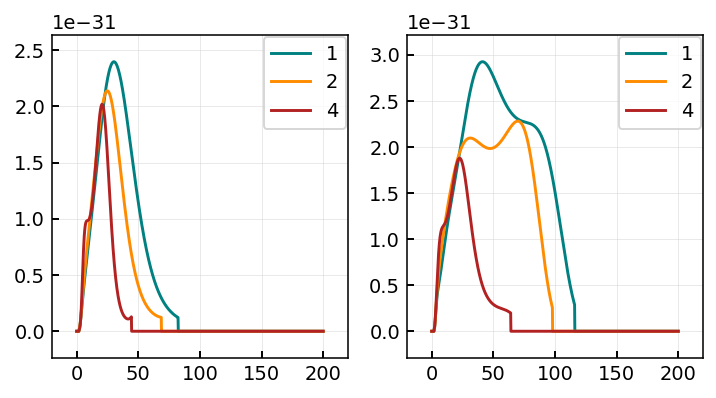

In [8]:
curves["extracted_outer"] = {}
curves["extracted_inner"] = {}

for i in range(8):
    curves["extracted_outer"][i] = store_slc[case].extract_cooling_curve("Ar", "outer_lower", sepadd = i, order = 10)
    curves["extracted_inner"][i] = store_slc[case].extract_cooling_curve("Ar", "inner_lower", sepadd = i, order = 8)
    
    
fig, axes = plt.subplots(1,2, figsize = (6,3))

for i in [1,2,4]:

    axes[0].plot(T, [curves["extracted_inner"][i](temp) for temp in T], label = i)
    axes[1].plot(T, [curves["extracted_outer"][i](temp) for temp in T], label = i)
    
for ax in axes:
    ax.legend()


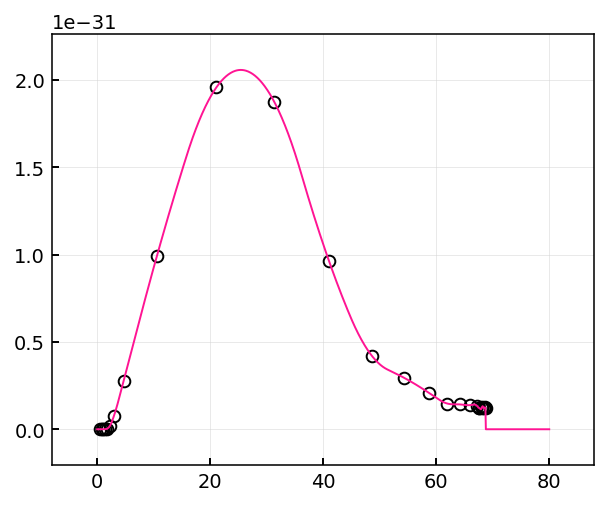

In [9]:
species = "Ar"
param_list = ["Te", f"R{species}", f"f{species}", "ne"]
self = store_slc[case]
sepadd = 2#sepadd_select["outer_lower"]

df = self.get_1d_poloidal_data(param_list, sepadd = sepadd, region = region, target_first = True)
df = df.sort_values(by = "Te")
df[f"R{species}"] = abs(df[f"R{species}"])

upper_limit = df["Te"].max()  # Upper validity limit

df["Lz"] = df[f"R{species}"]/(df["ne"]**2 * df[f"f{species}"])

interp = scipy.interpolate.interp1d(df["Te"], df["Lz"], bounds_error = False, fill_value = 0, kind = "quadratic")

T_new = np.linspace(0,80,1000)
Lz_fit = [interp(T) for T in T_new]

fig, ax = plt.subplots()

ax.plot(df["Te"], df["Lz"], lw = 0, marker = "o", c = "k", markerfacecolor = "None")
ax.plot(T_new, Lz_fit, lw = 1, c = "deeppink")
# ax.set_xlim(0,80)

## Custom

In [10]:
def LfuncArParametricTriShoulder(T, x1 = 0, x2 = 60, height = 0.5):
    """
    Analytical approximation of the Ar cooling curve
    Tmax is the temperature at which the radiation goes to zero on the hot end
    
    """
    
    # Maximum from actual Ar curve
    max = 1.7210363586464083e-31
    
    x0 = 0
    y0 = 0
    # x1 = max_pos
    y1 = max
    # x2 = 
    y2 = max * height
    

    if T < x1:
        Lz = (y0 * (x1 - T) + y1 * (T - x0)) / (x1 - x0)
    elif T >= x1 and T < x2:
        Lz = (y1 * (x2 - T) + y2 * (T - x1)) / (x2 - x1)
    else:
        Lz = y2

    
    return Lz

## Compare curves

### Outer

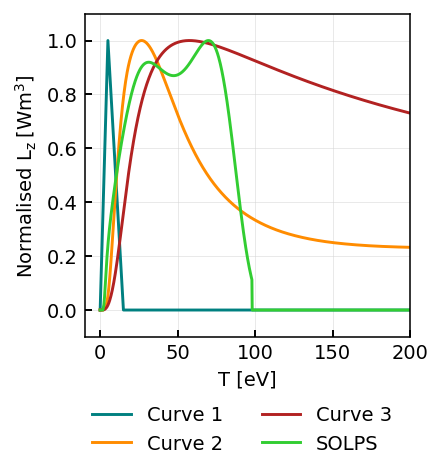

In [11]:
curves["set_outer"] = {
    "Curve 1" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 5, x2 = 15, height = 0),
    "Curve 2" : curves["neTau"][1e16],
    "Curve 3" : curves["neTau"][1e14],
    "SOLPS" : curves["extracted_outer"][sepadd_select["outer_lower"]],
    # "neon" : LfuncKallenbach("Ne")
    # "shoulder" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 23, x2 = 50, height = 0.27),
    # "nitrogen" : lambda temp: LfuncKallenbach("N")(temp),
    # "argon" : lambda temp: LfuncKallenbach("Ar")(temp),
    # "neon" : lambda temp: LfuncKallenbach("Ne")(temp),
    
}
    
fig, ax = plt.subplots(figsize = (3,3))


for name, function in curves["set_outer"].items():
    Lz = [function(temp) for temp in T]
    Lz = Lz/np.max(Lz)
    ax.plot(T, Lz, lw = 1.5, label = name)

ax.set_xlabel("T [eV]")
ax.set_ylabel(r"Normalised $L_z\ [W m^{3}]$")
fig.legend(loc = "upper center", bbox_to_anchor = (0.5,-0.03), ncol = 2, frameon = False)
ax.set_xlim(-10,200)
fig.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\FrontEffects_curves_outer.pdf", format = "pdf")

### Inner

In [135]:
sepadd_select

{'outer_lower': 2, 'inner_lower': 1}

(-10.0, 200.0)

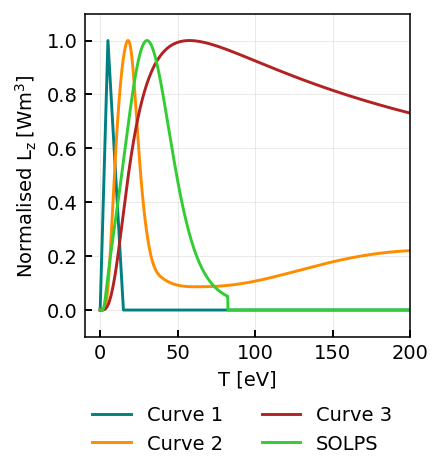

In [12]:
curves["set_inner"] = {
    "Curve 1" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 5, x2 = 15, height = 0),
    "Curve 2" : curves["neTau"][1e20],
    "Curve 3" : curves["neTau"][1e14],
    "SOLPS" : curves["extracted_inner"][sepadd_select["inner_lower"]],
    # "neon" : LfuncKallenbach("Ne")
    # "shoulder" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 23, x2 = 50, height = 0.27),
    # "nitrogen" : lambda temp: LfuncKallenbach("N")(temp),
    # "argon" : lambda temp: LfuncKallenbach("Ar")(temp),
    # "neon" : lambda temp: LfuncKallenbach("Ne")(temp),
    
}
    
fig, ax = plt.subplots(figsize = (3,3))


for name, function in curves["set_inner"].items():
    Lz = [function(temp) for temp in T]
    Lz = Lz/np.max(Lz)
    ax.plot(T, Lz, lw = 1.5, label = name)

ax.set_xlabel("T [eV]")
ax.set_ylabel(r"Normalised $L_z\ [W m^{3}]$")
fig.legend(loc = "upper center", bbox_to_anchor = (0.5,-0.03), ncol = 2, frameon = False)
ax.set_xlim(-10,200)
# fig.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\FrontEffects_curves_inner.pdf", format = "pdf")

# Outer profiles

In [13]:
store_profiles = {}
store_profiles["outer"] = {}
store_profiles["inner"] = {}

## f_R

In [14]:
p = eqb[case]["outer_lower"][sepadd_select["outer_lower"]]
base_profile = Profile(p["R"], p["Z"], p["Xpoint"], p["Btot"], p["Bpol"], p["S"], p["Spol"], name = "base")

Text(0.5, 1.0, 'Flux expansion profiles')

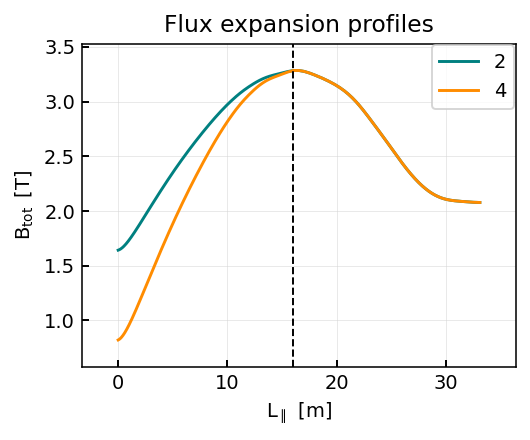

In [15]:
list_fR = [2, 4]
store_profiles["outer"]["fR"] = {}

fig, ax = plt.subplots(figsize = (4,3))

for fR in list_fR:
    store_profiles["outer"]["fR"][fR] = copy.deepcopy(base_profile)
    store_profiles["outer"]["fR"][fR].scale_BxBt(BxBt = fR)
    
    ax.plot(store_profiles["outer"]["fR"][fR]["S"], store_profiles["outer"]["fR"][fR]["Btot"], label = fR)
    
ylims = ax.get_ylim()
ax.vlines(base_profile["S"][base_profile["Xpoint"]], *ylims, color = "k", lw = 1.0, linestyle = "--")
ax.set_ylim(ylims)
ax.legend()
ax.set_xlabel("$L_{\parallel}\ \ [m]$")
ax.set_ylabel("$B_{tot}\ \ [T]$")
ax.set_title("Flux expansion profiles")

## Lc

Text(0.5, 1.0, 'Flux expansion profiles')

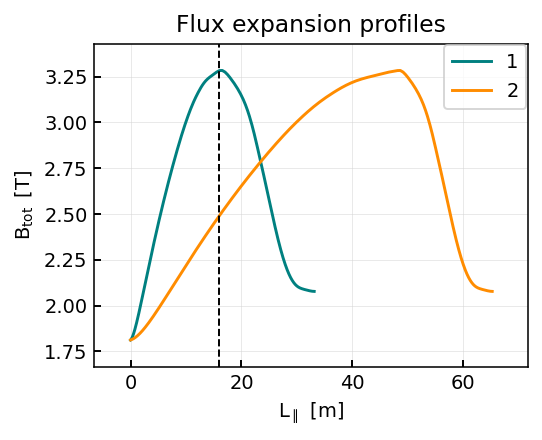

In [16]:
list_Lc_factors = [1, 2]
store_profiles["outer"]["Lc"] = {}

fig, ax = plt.subplots(figsize = (4,3))

for Lc_factor in list_Lc_factors:
    store_profiles["outer"]["Lc"][Lc_factor] = copy.deepcopy(base_profile)
    store_profiles["outer"]["Lc"][Lc_factor].scale_Lc(scale_factor = Lc_factor)
    
    ax.plot(store_profiles["outer"]["Lc"][Lc_factor]["S"], store_profiles["outer"]["Lc"][Lc_factor]["Btot"], label = Lc_factor)
    
ylims = ax.get_ylim()
ax.vlines(base_profile["S"][base_profile["Xpoint"]], *ylims, color = "k", lw = 1.0, linestyle = "--")
ax.set_ylim(ylims)
ax.legend()
ax.set_xlabel("$L_{\parallel}\ \ [m]$")
ax.set_ylabel("$B_{tot}\ \ [T]$")
ax.set_title("Flux expansion profiles")

## Paper profile plot

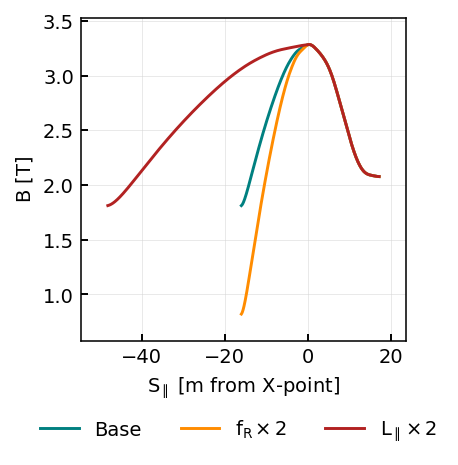

In [17]:
fig, ax = plt.subplots(figsize = (3,3))

profiles = dict(
    base = base_profile,
    fR = store_profiles["outer"]["fR"][4],
    Lc = store_profiles["outer"]["Lc"][2]
)

Sx = profiles["base"]["S"][profiles["base"]["Xpoint"]]

ax.plot(profiles["base"]["S"] - profiles["base"]["S"][profiles["base"]["Xpoint"]], profiles["base"]["Btot"], label = "Base")
ax.plot(profiles["fR"]["S"] - profiles["fR"]["S"][profiles["fR"]["Xpoint"]], profiles["fR"]["Btot"], label = r"$f_{R} \times 2$")
ax.plot(profiles["Lc"]["S"] - profiles["Lc"]["S"][profiles["Lc"]["Xpoint"]],  profiles["Lc"]["Btot"], label = r"$L_{\parallel} \times 2$")

ax.set_xlabel("$S_{\parallel}$ [m from X-point]")
ax.set_ylabel("$B$ [T]")
fig.legend(loc = "upper center", bbox_to_anchor = (0.5, -0.05), ncols = 3, frameon = False)

fig.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\FrontEffects_profiles_outer.pdf", format = "pdf")

# Inner profiles

## f_R

In [18]:
p = eqb[case]["inner_lower"][sepadd_select["inner_lower"]]
base_profile = Profile(p["R"], p["Z"], p["Xpoint"], p["Btot"], p["Bpol"], p["S"], p["Spol"], name = "base")

Text(0.5, 1.0, 'Flux expansion profiles')

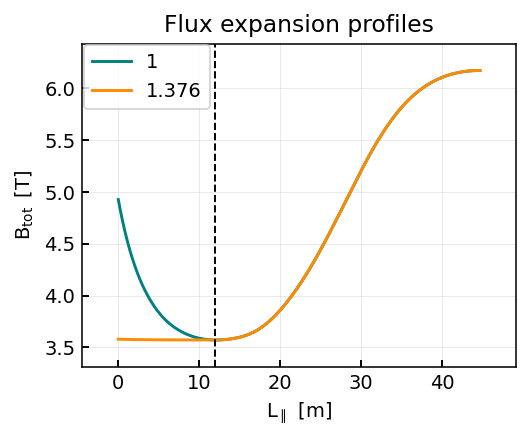

In [19]:
list_fR_factors = [1,1.376]
store_profiles["inner"]["fR"] = {}

fig, ax = plt.subplots(figsize = (4,3))

for fR in list_fR_factors:
    store_profiles["inner"]["fR"][fR] = copy.deepcopy(base_profile)
    store_profiles["inner"]["fR"][fR].scale_BxBt(scale_factor = fR)
    
    ax.plot(store_profiles["inner"]["fR"][fR]["S"], store_profiles["inner"]["fR"][fR]["Btot"], label = fR)
    
ylims = ax.get_ylim()
ax.vlines(base_profile["S"][base_profile["Xpoint"]], *ylims, color = "k", lw = 1.0, linestyle = "--")
ax.set_ylim(ylims)
ax.legend()
ax.set_xlabel("$L_{\parallel}\ \ [m]$")
ax.set_ylabel("$B_{tot}\ \ [T]$")
ax.set_title("Flux expansion profiles")

## Lc

Text(0.5, 1.0, 'Flux expansion profiles')

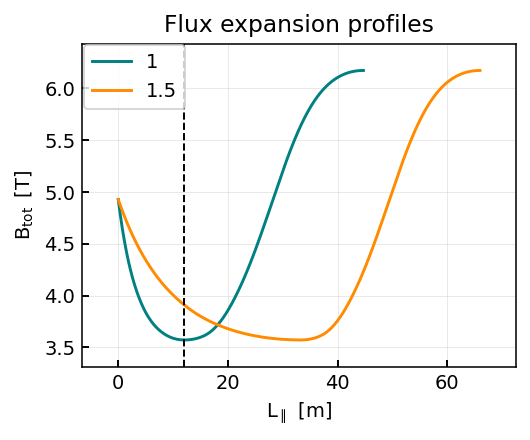

In [20]:
list_Lc_factors = [1, 1.5]
store_profiles["inner"]["Lc"] = {}

fig, ax = plt.subplots(figsize = (4,3))

for Lc_factor in list_Lc_factors:
    store_profiles["inner"]["Lc"][Lc_factor] = copy.deepcopy(base_profile)
    store_profiles["inner"]["Lc"][Lc_factor].scale_Lc(scale_factor = Lc_factor)
    
    ax.plot(store_profiles["inner"]["Lc"][Lc_factor]["S"], store_profiles["inner"]["Lc"][Lc_factor]["Btot"], label = Lc_factor)
    
ylims = ax.get_ylim()
ax.vlines(base_profile["S"][base_profile["Xpoint"]], *ylims, color = "k", lw = 1.0, linestyle = "--")
ax.set_ylim(ylims)
ax.legend()
ax.set_xlabel("$L_{\parallel}\ \ [m]$")
ax.set_ylabel("$B_{tot}\ \ [T]$")
ax.set_title("Flux expansion profiles")

## Paper profile plot

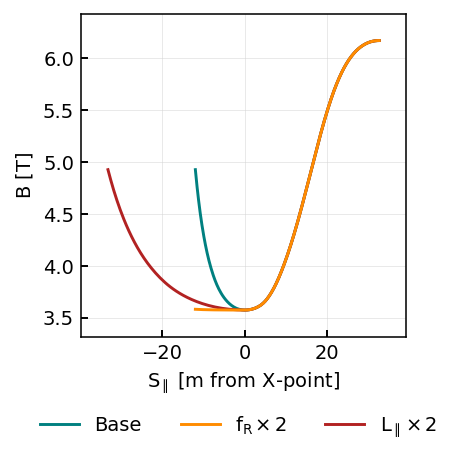

In [21]:
fig, ax = plt.subplots(figsize = (3,3))

profiles = dict(
    base = base_profile,
    fR = store_profiles["inner"]["fR"][list_fR_factors[-1]],
    Lc = store_profiles["inner"]["Lc"][list_Lc_factors[-1]]
)

Sx = profiles["base"]["S"][profiles["base"]["Xpoint"]]

ax.plot(profiles["base"]["S"] - profiles["base"]["S"][profiles["base"]["Xpoint"]], profiles["base"]["Btot"], label = "Base")
ax.plot(profiles["fR"]["S"] - profiles["fR"]["S"][profiles["fR"]["Xpoint"]], profiles["fR"]["Btot"], label = r"$f_{R} \times 2$", zorder = 50)
ax.plot(profiles["Lc"]["S"] - profiles["Lc"]["S"][profiles["Lc"]["Xpoint"]],  profiles["Lc"]["Btot"], label = r"$L_{\parallel} \times 2$")

ax.set_xlabel("$S_{\parallel}$ [m from X-point]")
ax.set_ylabel("$B$ [T]")
fig.legend(loc = "upper center", bbox_to_anchor = (0.5, -0.05), ncols = 3, frameon = False)

fig.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\FrontEffects_profiles_inner.pdf", format = "pdf")

# DLS run definition

In [39]:
def run_DLS(constants_input, profile, Spar, slc, cvar, region, sepadd, hflux_corr = 1):
    if "Lfunc" not in constants_input.keys():
        print("WARNING: NO COOLING CURVE PROVIDED")
    # set switches
    radios_default = {
        "upstreamGrid": True,  # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point.
    }
    
    df = slc.get_1d_poloidal_data(["Ne"], sepadd = sepadd, region = region, target_first = True)
    nu = df["Ne"].iloc[-1]

    # set general run parameters
    constants_default = {
        "gamma_sheath": 7,  # sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
        "Tt": 0.5,  # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
        "qpllu0": 3.42e8,
        "nu": nu,  # Upstream density (if constant)
        "nu0": nu,  # Upstream density (if constant)
        "cz0": 0.05,  # Impurity fraction (if constant)
        # "Lfunc": LfuncKallenbach("N"),  # impurity cooling function. More are available in AnalyticCoolingCurves.py
        "Lfunc" : slc.extract_cooling_curve("Ar", region, sepadd = sepadd, plot = False),
        "kappa0" : slc.extract_kappa0(sepadd = sepadd, region = region)
    }
    
    if Spar == "auto":
        Spar = slc.extract_front_pos(sepadd = sepadd, region = region, impurity = "Ar", method = "qpar_tot", threshold = 0.05)

    constants = {**constants_default, **constants_input}

    try: 
            out = run_dls(
                constants = constants, 
                radios = radios_default, 
                d = profile,
                SparRange = [Spar],
                control_variable = cvar,
                verbosity = 0,
                Ctol = 1e-4,
                Ttol = 1e-4,
                dynamicGrid = True,
                dynamicGridRefinementRatio = 5,
                dynamicGridRefinementWidth = 2,
                dynamicGridResolution = 10000,
                dynamicGridDiagnosticPlot = False)
        
    except KeyboardInterrupt:
        print("Stopped")
        sys.exit(0)

    return out, compare_SOLPS_DLS(slc, out, cvar, impurity = "Ar", region = region, sepadd = sepadd)

comps_outer = {}
store_outer = {}
comps_inner = {}
store_inner = {}

In [40]:
region = "outer_lower"
slc = store_slc[case]

# Run outer

In [41]:
## Get hflux
df = slc.get_1d_poloidal_data(params = ["fhx_total", "Ne"], sepadd = sepadd_select[region], region = region, target_first = True)
qpar_max = (df["fhx_total"]/df["apar"]).abs().max()
print(f"{qpar_max:.1e}")

## Get front location
floc = slc.extract_front_pos(sepadd = sepadd_select[region], region = region, impurity = "Ar", method = "qpar_total", threshold = 0.05)
print(f"{floc:.3f}")

3.1e+08
0.383


## Baseline

Solving...0.38...Complete in 2.0 seconds


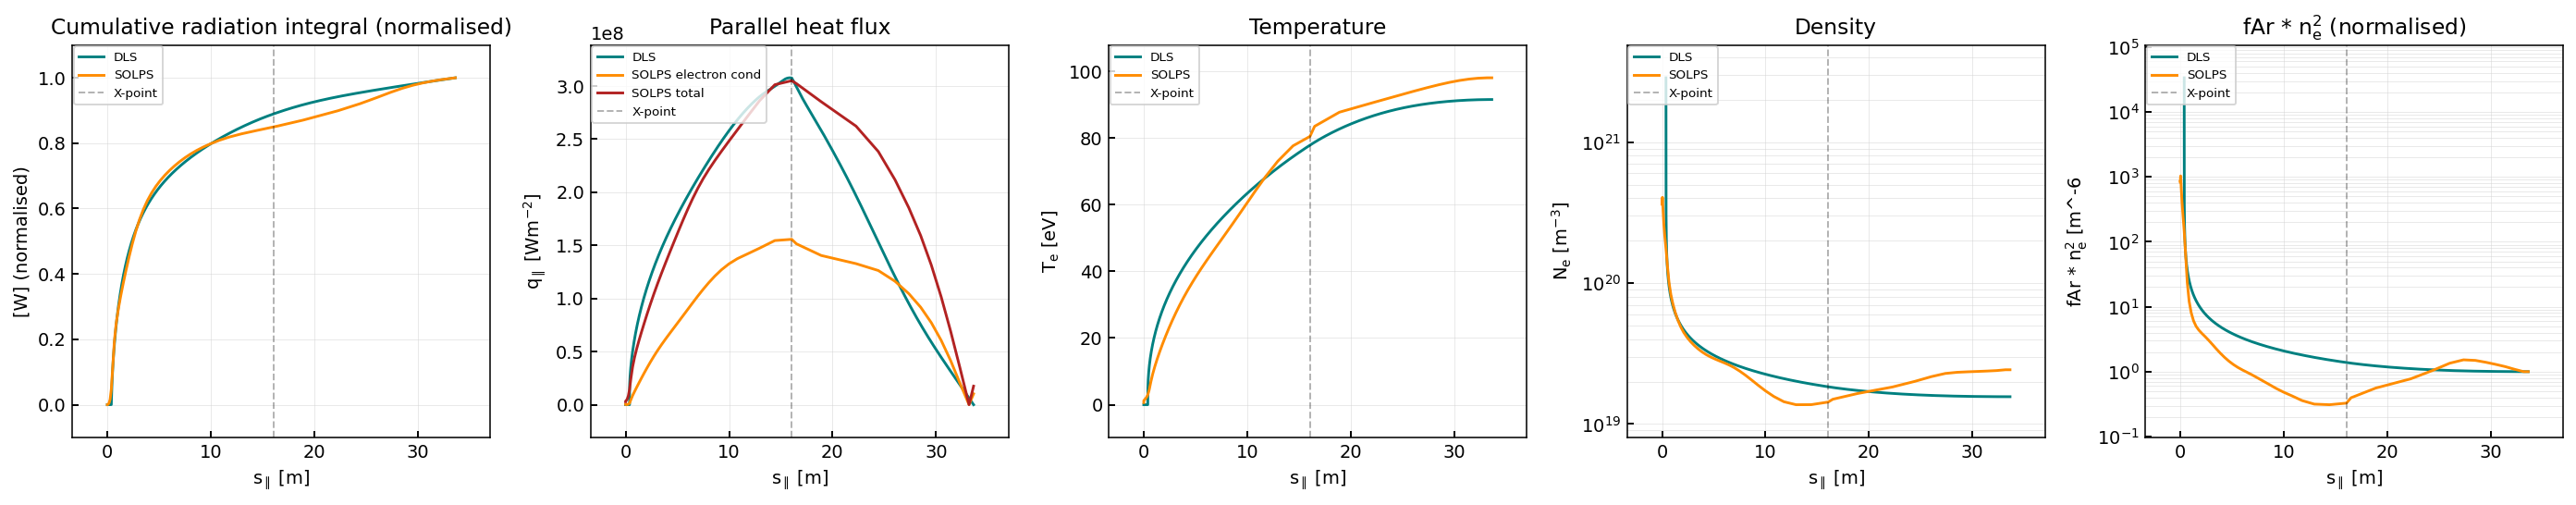

In [42]:
region = "outer_lower"
input = {
    "qpllu0" : 3.42e8,
    "Lfunc" : curves["set_outer"]["SOLPS"]
}

_, comp = run_DLS(input, eqb_alt[case][region][sepadd_select[region]], "auto", store_slc[case],  "density", region, sepadd_select[region], hflux_corr = 1)  
comp.plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False)

## Flux expansion

In [100]:
study = "base"
region = "outer_lower"
study = "fR"
comps_outer[study] = {}
store_outer[study] = {}

for curve in curves["set_outer"].keys():
    
    print(f"Solving curve {curve} ------")
    
    comps_outer[study][curve] = {}
    store_outer[study][curve] = {}
    
    input = dict(Lfunc = curves["set_outer"][curve])

    for i in store_profiles["outer"][study].keys():
        print(f"Solving fR {i} ------")
        out, comp = run_DLS(input, store_profiles["outer"]["fR"][i], "auto", store_slc[case],  "density", region, sepadd_select[region], hflux_corr = 1)  
        comps_outer[study][curve][i] = comp
        store_outer[study][curve][i] = out
    
# comp.plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False)

Solving curve Curve 1 ------
Solving fR 2 ------
Solving...0.38...Complete in 1.8 seconds
Solving fR 4 ------
Solving...0.38...Complete in 1.7 seconds
Solving curve Curve 2 ------
Solving fR 2 ------
Solving...0.38...Complete in 1.8 seconds
Solving fR 4 ------
Solving...0.38...Complete in 2.3 seconds
Solving curve Curve 3 ------
Solving fR 2 ------
Solving...0.38...Complete in 1.9 seconds
Solving fR 4 ------
Solving...0.38...Complete in 1.7 seconds
Solving curve SOLPS ------
Solving fR 2 ------
Solving...0.38...Complete in 2.5 seconds
Solving fR 4 ------
Solving...0.38...Complete in 1.9 seconds


## Connection length

In [101]:
study = "base"
region = "outer_lower"
study = "Lc"
comps_outer[study] = {}
store_outer[study] = {}

for curve in curves["set_outer"].keys():
    
    print(f"Solving curve {curve} ------")
    
    comps_outer[study][curve] = {}
    store_outer[study][curve] = {}
    
    input = dict(Lfunc = curves["set_outer"][curve])

    for i in store_profiles["outer"][study].keys():
        print(f"Solving {study} {i} ------")
        out, comp = run_DLS(input, store_profiles["outer"][study][i], "auto", store_slc[case],  "density", region, sepadd_select[region], hflux_corr = 1)  
        comps_outer[study][curve][i] = comp
        store_outer[study][curve][i] = out
    
# comp.plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False)

Solving curve Curve 1 ------
Solving Lc 1 ------
Solving...0.38...Complete in 1.5 seconds
Solving Lc 2 ------
Solving...0.38...Complete in 1.6 seconds
Solving curve Curve 2 ------
Solving Lc 1 ------
Solving...0.38...Complete in 1.9 seconds
Solving Lc 2 ------
Solving...0.38...Complete in 1.9 seconds
Solving curve Curve 3 ------
Solving Lc 1 ------
Solving...0.38...Complete in 2.1 seconds
Solving Lc 2 ------
Solving...0.38...Complete in 2.2 seconds
Solving curve SOLPS ------
Solving Lc 1 ------
Solving...0.38...Complete in 1.7 seconds
Solving Lc 2 ------
Solving...0.38...Complete in 2.0 seconds


# Run inner

## Baseline

Solving...0.00...Complete in 1.4 seconds


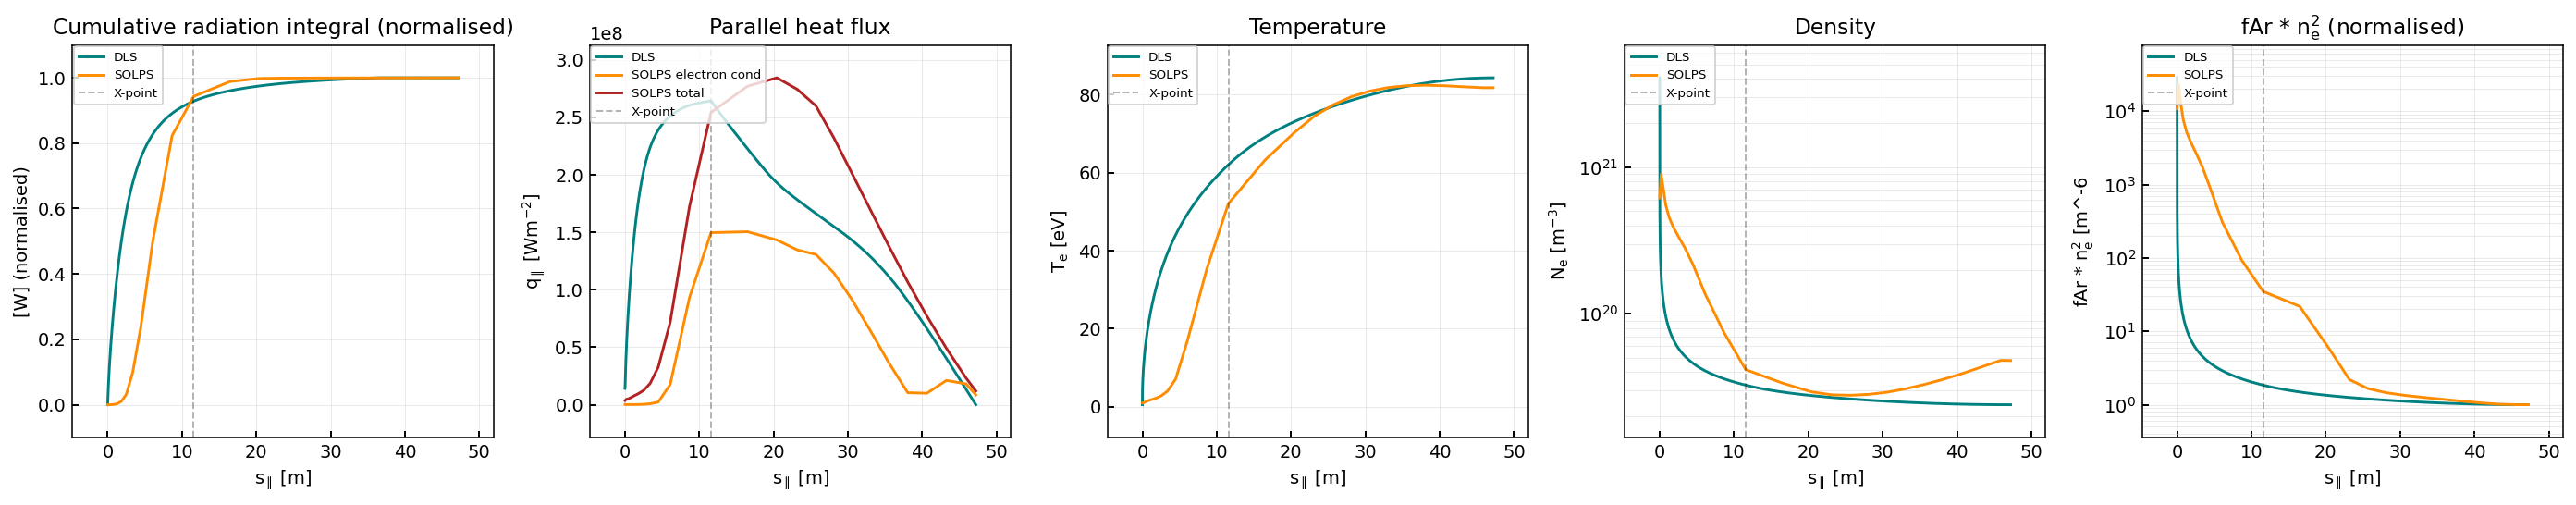

In [137]:
region = "inner_lower"
input = {
    "qpllu0" : 3.42e8 * 0.83,
    "kappa0" : 2800 * 1.73,
    "Lfunc" : curves["set_inner"]["SOLPS"]
}

_, comp = run_DLS(input, eqb_alt[case][region][sepadd_select[region]], 0, store_slc[case],  "density", region, sepadd_select[region], hflux_corr = 1)  
comp.plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False)

## Flux expansion

In [138]:
study = "base"
region = "inner_lower"
study = "fR"
comps_inner[study] = {}
store_inner[study] = {}

for curve in curves["set_inner"].keys():
    
    print(f"Solving curve {curve} ------")
    
    comps_inner[study][curve] = {}
    store_inner[study][curve] = {}
    
    input = dict(
        Lfunc = curves["set_inner"][curve],
        qpllu0 = 3.42e8 * 0.83,
        kappa0 = 2800 * 1.73,
        )

    for i in store_profiles["inner"][study].keys():
        print(f"Solving fR {i} ------")
        out, comp = run_DLS(input, store_profiles["inner"]["fR"][i], 0, store_slc[case],  "density", region, sepadd_select[region], hflux_corr = 1)  
        comps_inner[study][curve][i] = comp
        store_inner[study][curve][i] = out
    
# comp.plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False)

Solving curve Curve 1 ------
Solving fR 1 ------
Solving...0.00...Complete in 1.3 seconds
Solving fR 1.376 ------
Solving...0.00...Complete in 1.5 seconds
Solving curve Curve 2 ------
Solving fR 1 ------
Solving...0.00...

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


Complete in 2.1 seconds
Solving fR 1.376 ------
Solving...0.00...

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


Complete in 2.4 seconds
Solving curve Curve 3 ------
Solving fR 1 ------
Solving...0.00...

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


Complete in 2.5 seconds
Solving fR 1.376 ------
Solving...0.00...

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


Complete in 3.0 seconds
Solving curve SOLPS ------
Solving fR 1 ------
Solving...0.00...Complete in 2.2 seconds
Solving fR 1.376 ------
Solving...0.00...

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


Complete in 2.9 seconds


## Connection length

In [139]:
study = "base"
region = "inner_lower"
study = "Lc"
comps_inner[study] = {}
store_inner[study] = {}

for curve in curves["set_inner"].keys():
    
    print(f"Solving curve {curve} ------")
    
    comps_inner[study][curve] = {}
    store_inner[study][curve] = {}
    
    input = dict(
        Lfunc = curves["set_inner"][curve],
        qpllu0 = 3.42e8 * 0.83,
        kappa0 = 2800 * 1.73,
        )

    for i in store_profiles["inner"][study].keys():
        print(f"Solving {study} {i} ------")
        out, comp = run_DLS(input, store_profiles["inner"][study][i], 0, store_slc[case],  "density", region, sepadd_select[region], hflux_corr = 1)  
        comps_inner[study][curve][i] = comp
        store_inner[study][curve][i] = out
    
# comp.plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False)

Solving curve Curve 1 ------
Solving Lc 1 ------
Solving...0.00...Complete in 1.9 seconds
Solving Lc 1.5 ------
Solving...0.00...Complete in 2.0 seconds
Solving curve Curve 2 ------
Solving Lc 1 ------
Solving...0.00...

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


Complete in 2.9 seconds
Solving Lc 1.5 ------
Solving...0.00...Complete in 2.9 seconds
Solving curve Curve 3 ------
Solving Lc 1 ------
Solving...0.00...

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


Complete in 3.0 seconds
Solving Lc 1.5 ------
Solving...0.00...

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


Complete in 3.3 seconds
Solving curve SOLPS ------
Solving Lc 1 ------
Solving...0.00...Complete in 2.1 seconds
Solving Lc 1.5 ------
Solving...0.00...Complete in 2.3 seconds


# Scalings breakdown

## Prepare data

In [45]:
comps_outer["fR"].keys()

dict_keys(['Curve 1', 'Curve 2', 'Curve 3', 'SOLPS'])

In [62]:
from collections import defaultdict

In [66]:
test = defaultdict(dict)
test["test"]

{}

In [36]:
# param = "Lc"
# study_name = "Lc"

param = "BxBt"
study_name = "fR"
side = "outer"

store_choices = dict(inner = store_inner, outer = store_outer)
comps_choices = dict(inner = comps_inner, outer = comps_outer)


allchecks = {}
allterms = {}
allsc = {}
all_plotweights = {}

analytical = {} 

params = ["Lc", "BxBt"]
studies = ["Lc", "fR"]
# studies = ["Lc"]

for i, study in enumerate(studies):
    param = params[i]
    plot_weights = pd.DataFrame()
    analytical[study] = pd.DataFrame()

    for curve_name in curves[f"set_{side}"].keys():

        store = store_choices[side][study][curve_name]
        names = list(store.keys())

        sc = scaling_comparison(store[names[0]], store[names[-1]], param)
        allsc[curve_name] = sc
        allterms[curve_name] = sc.terms.copy()
        allchecks[curve_name] = sc.terms_check.copy()
        plot_weights[curve_name] = sc.terms["weights"]
        
        ## Calculate analytical results for just Lpar/fR and for full analytical DLS with upstream and avgB ratio
        ratio = sc.terms_full["ratio"]
        param_ratio = ratio[param]
        simple = ratio["BxBt"] * ratio["Lc"]**(2/7)
        simple_avgB = ratio["BxBt"] * ratio["Lc"]**(2/7) * ratio["avgB_ratio"]**(-2/7)
        full = ratio["BxBt"] * ratio["avgB_ratio"]**(-2/7) * ratio["W_Tu_simple"]**(-1)
        
        analytical[study].loc["simple", curve_name] = np.log(simple) / np.log(param_ratio)
        analytical[study].loc["simple_avgB", curve_name] = np.log(simple_avgB) / np.log(param_ratio)
        analytical[study].loc["full", curve_name] = np.log(full) / np.log(param_ratio)
        
    all_plotweights[study] = plot_weights
        

## Prepare plot

In [186]:
bar_alpha = 0.5

param_labels = dict(
    Beff = "A: $B_{eff}$",
    W_Tu = r"B: $\frac{W_{radial}^{2/7}}{T_{u}}$",
    curveclip = r"C: ${\sqrt{2\int^{T_{u}}_{T_{f}} \kappa_{e0} T^{1/2}  L_{\alpha}(T) }dT}$", 
    upstream_rad = r"D: $\left(\sqrt{2 \int^{s=L_{||}}_{s=s_{X}} \frac{q_{||}}{W_{radial}B^{2}}ds}\right)^{-1}$"
    )

param_colors = dict(
    Beff = "teal",
    W_Tu = "darkorange",   
    curveclip = "firebrick",
    upstream_rad = "limegreen"
)

ylabels = dict(Lc = "$K_{L_{\parallel}}$", fR = "$K_{f_{R}}$")
titles = dict(Lc = "$L_{\parallel}$", fR = "$f_{R}$")

analytical_scaling = dict(Lc = 2/7, fR = 1)

handles = []
for param in param_labels:
    handles.append(mpl.patches.Patch(color = param_colors[param], label = param_labels[param], alpha = bar_alpha*0.7, linewidth = 0))
    
handles_line = [mpl.lines.Line2D([], [], color = "deeppink", lw = 2, ls = ":", label = "Analytical: $K_{L_{\parallel}}=2/7=0.29$, $K_{f_{R}}=1$")]

## Plot for paper

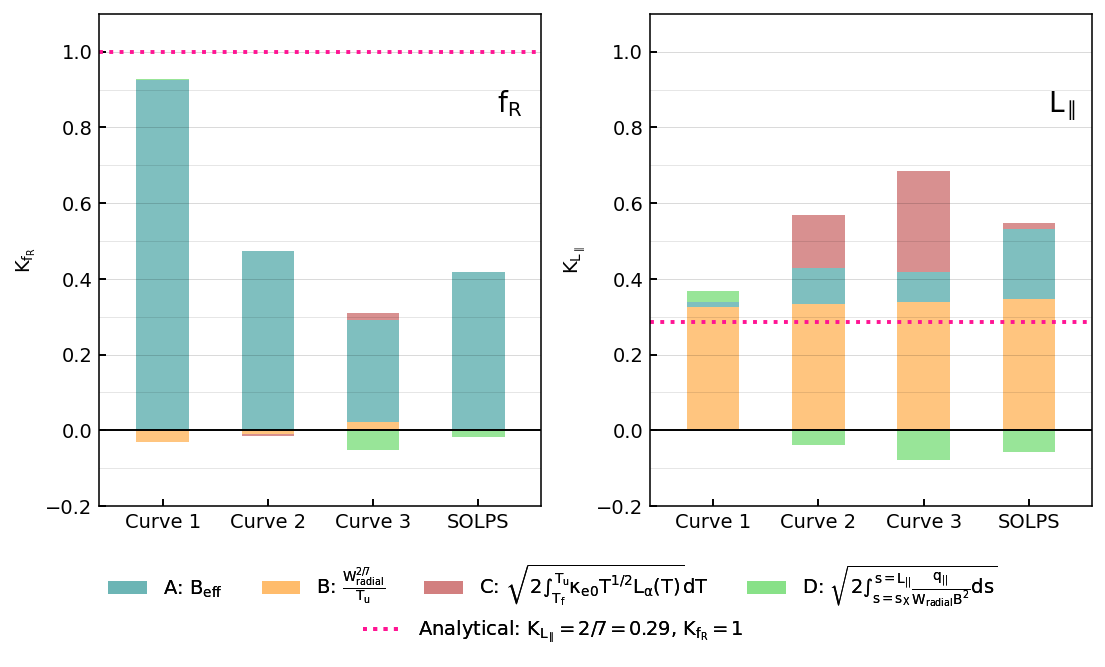

In [38]:
fig, axes = plt.subplots(1,2, figsize = (8,4))

for i, study in enumerate(studies[::-1]):
    ax = axes[i]

    plot_weights = all_plotweights[study].reindex(["W_Tu", "Beff", "curveclip", "upstream_rad"])
    weight_counts_pos = {}
    weight_counts_neg = {}
    for param in plot_weights.index:
        weight_counts_neg[param] = plot_weights[plot_weights < 0].fillna(0).loc[param, :]
        weight_counts_pos[param] = plot_weights[plot_weights > 0].fillna(0).loc[param, :]
        
    bottom_pos = np.zeros_like(weight_counts_pos[param])
    bottom_neg = np.zeros_like(weight_counts_pos[param])

    width = 0.5
    for param, weight_counts_neg in weight_counts_neg.items():
        p = ax.bar(curves[f"set_{side}"].keys(), weight_counts_neg, width, bottom = bottom_neg, alpha = bar_alpha, color = param_colors[param])
        bottom_neg += weight_counts_neg
        
    for param, weight_counts_pos in weight_counts_pos.items():
        p = ax.bar(curves[f"set_{side}"].keys(), weight_counts_pos, width, bottom = bottom_pos, alpha = bar_alpha, color = param_colors[param])
        bottom_pos += weight_counts_pos
        
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax.grid(axis = "x", which = "both", visible = False)
    ax.grid(axis = "y", which = "major", c = "k", alpha = 0.15)
    ax.grid(axis = "y", which = "minor", c = "k", alpha = 0.1)
    ax.set_ylim(-0.2, 1.1)
    xlim = ax.get_xlim()
    ax.hlines(0, *xlim, color = "k", lw = 1, linestyle = "-")
    ax.set_xlim(xlim)
    fig.legend(handles=handles, ncols = 4, loc = "upper center", bbox_to_anchor = (0.5, 0.0), frameon = False)
    fig.legend(handles=handles_line, ncols = 4, loc = "upper center", bbox_to_anchor = (0.5, -0.1), frameon = False)
    ax.set_ylabel(ylabels[study])
    ax.text(0.9, 0.8, titles[study], fontsize = "x-large", transform=ax.transAxes)
    xlim = ax.get_xlim()
    ax.hlines(analytical_scaling[study], *xlim, color = "deeppink", lw = 2, linestyle = ":")
    # ax.set_title(titles[study], loc = "right", transform=ax.transAxes)

fig.tight_layout()
# fig.savefig(fr"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\FrontEffects_K_{side}_lower.pdf", format = "pdf")

## Plot for synopsis

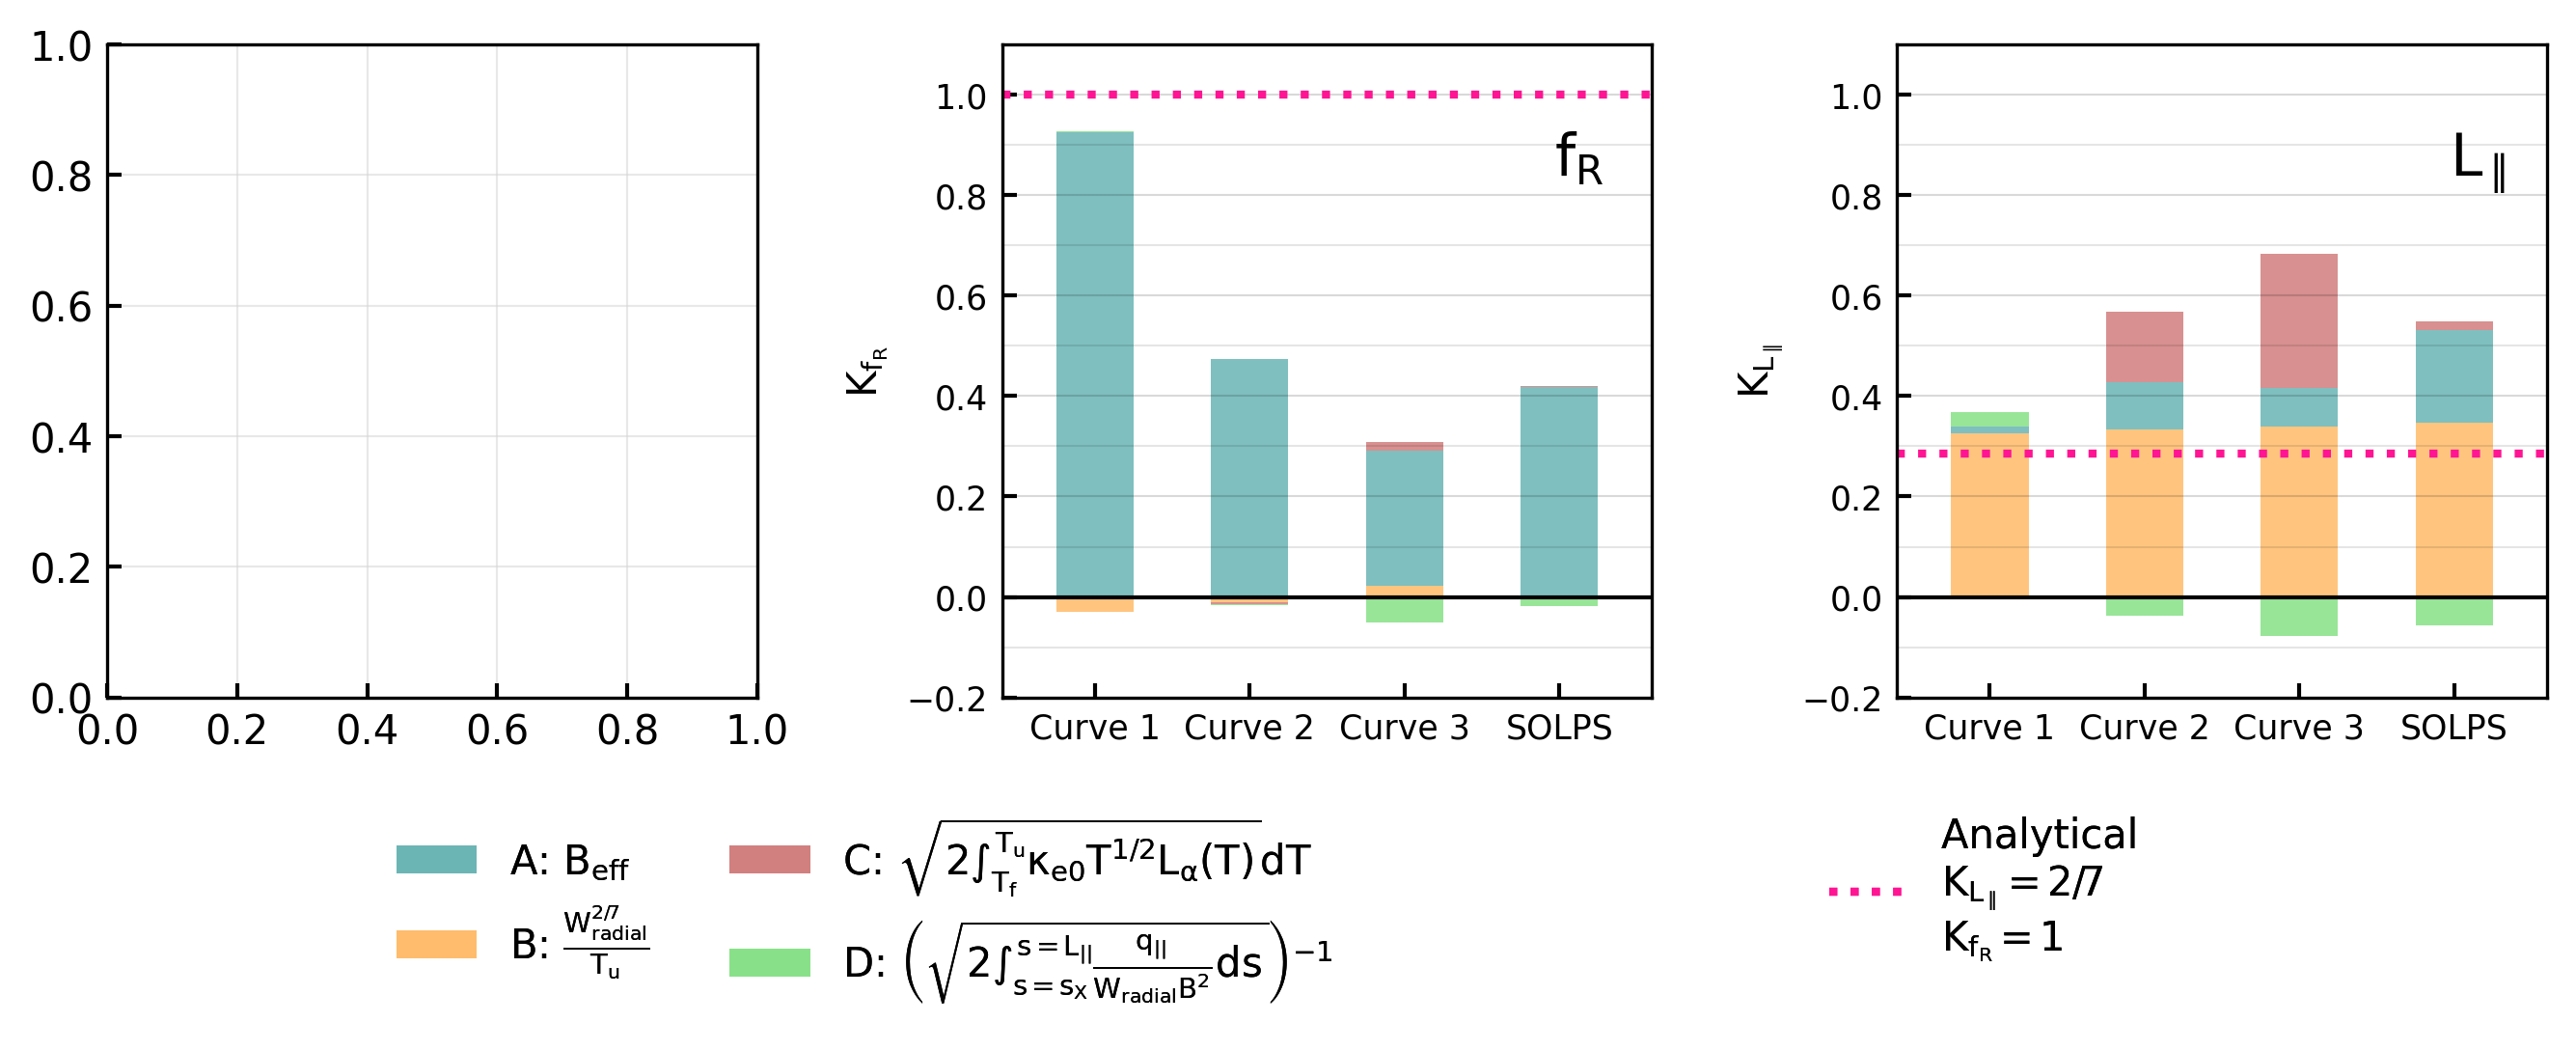

In [ ]:
fig, axes = plt.subplots(1,3, figsize = (9,2.8), dpi = 300)

for i, study in enumerate(studies[::-1]):
    ax = axes[i+1]

    plot_weights = all_plotweights[study].reindex(["W_Tu", "Beff", "curveclip", "upstream_rad"])
    weight_counts_pos = {}
    weight_counts_neg = {}
    for param in plot_weights.index:
        weight_counts_neg[param] = plot_weights[plot_weights < 0].fillna(0).loc[param, :]
        weight_counts_pos[param] = plot_weights[plot_weights > 0].fillna(0).loc[param, :]
        
    bottom_pos = np.zeros_like(weight_counts_pos[param])
    bottom_neg = np.zeros_like(weight_counts_pos[param])

    width = 0.5
    for param, weight_counts_neg in weight_counts_neg.items():
        p = ax.bar(curves[f"set_{side}"].keys(), weight_counts_neg, width, bottom = bottom_neg, alpha = bar_alpha, color = param_colors[param])
        bottom_neg += weight_counts_neg
        
    for param, weight_counts_pos in weight_counts_pos.items():
        p = ax.bar(curves[f"set_{side}"].keys(), weight_counts_pos, width, bottom = bottom_pos, alpha = bar_alpha, color = param_colors[param])
        bottom_pos += weight_counts_pos
        
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax.grid(axis = "x", which = "both", visible = False)
    ax.grid(axis = "y", which = "major", c = "k", alpha = 0.15)
    ax.grid(axis = "y", which = "minor", c = "k", alpha = 0.1)
    ax.set_ylim(-0.2, 1.1)
    xlim = ax.get_xlim()
    ax.hlines(0, *xlim, color = "k", lw = 1, linestyle = "-")
    ax.set_xlim(xlim)
    
    handles_line[0].set_label("Analytical \n$K_{L_{\parallel}}=2/7$ \n$K_{f_{R}}=1$")
    fig.legend(handles=handles, ncols = 2, loc = "upper left", bbox_to_anchor = (0.15, 0.0), frameon = False)
    fig.legend(handles=handles_line, ncols = 1, loc = "upper left", bbox_to_anchor = (0.7, 0), frameon = False)
    ax.set_ylabel(ylabels[study])
    ax.text(0.85, 0.8, titles[study], fontsize = "x-large", transform=ax.transAxes)
    xlim = ax.get_xlim()
    ax.hlines(analytical_scaling[study], *xlim, color = "deeppink", lw = 2, linestyle = ":")
    ax.tick_params(axis = "both", labelsize = "small")
    # ax.set_title(titles[study], loc = "right", transform=ax.transAxes)

axes[0]
fig.tight_layout()
# fig.savefig(fr"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\FrontEffects_K_{side}_lower.pdf", format = "pdf")

## Deep dive into scalings

In [32]:
allsc["Curve 1"].terms_full

,base,test,ratio
cvar,5.901549e+19,3.062434e+19,1.927078
kappa0,2.861095e+03,2.861095e+03,1.000000
Bf,1.641611e+00,8.208055e-01,2.000000
Bx,3.283211e+00,3.283207e+00,1.000001
Beff,1.665725e+00,8.585379e-01,1.940188
BxBt,1.999993e+00,3.999981e+00,0.500001
BxBteff,1.971041e+00,3.824183e+00,0.515415
Lc,8.348459e+00,8.348459e+00,1.000000
Wradial,1.567775e+07,1.567779e+07,0.999997
Tu,9.629791e+01,9.431496e+01,1.021025


### Debug analytical stuff
- With upstream doesn't work

In [ ]:
analytical["Lc"]

,SOLPS,Curve 1,Curve 2,Curve 3
simple,0.285713,0.285713,0.285713,0.285713
simple_avgB,0.285706,0.285706,0.285706,0.285706
full,0.137256,0.137256,0.137256,0.137256


In [ ]:
df = allsc["Curve 1"].terms_full.loc[["BxBt", "Lc", "avgB_ratio", "W_Tu_simple"]]
df.loc["BxBt", "factor"] = df["ratio"]["BxBt"]**(1)
df.loc["Lc", "factor"] = df["ratio"]["Lc"]**(2/7)
df.loc["avgB_ratio", "factor"] = df["ratio"]["avgB_ratio"]**(-2/7)
df.loc["W_Tu_simple", "factor"] = df["ratio"]["W_Tu_simple"]**(-1)
df

,base,test,ratio,factor
BxBt,1.811895,1.811893,1.000001,1.000001
Lc,8.348459,16.652238,0.501342,0.820964
avgB_ratio,1.211503,1.211524,0.999983,1.000005
W_Tu_simple,0.346577,0.315238,1.099413,0.909576


In [ ]:
np.log(df["factor"].sum(axis = 0)) / np.log(0.5)

-1.9709945845420858

In [ ]:
ratio = df["ratio"][["BxBt", "Lc", "avgB_ratio", "W_Tu_simple"]]
ratio["test"] = 1
display(ratio)
np.log(ratio.product()) / np.log(param_ratio)

BxBt           1.000001
Lc             0.501342
avgB_ratio     0.999983
W_Tu_simple    1.099413
test           1.000000
Name: ratio, dtype: float64

0.8627587892291205

In [ ]:
allsc["Curve 1"].terms_full

,base,test,ratio
cvar,6.526569e+19,5.092413e+19,1.281626
kappa0,2.861095e+03,2.861095e+03,1.000000
Bf,1.812058e+00,1.812058e+00,1.000000
Bx,3.283259e+00,3.283255e+00,1.000001
Beff,1.833578e+00,1.816923e+00,1.009166
BxBt,1.811895e+00,1.811893e+00,1.000001
BxBteff,1.790630e+00,1.807041e+00,0.990918
Lc,8.348459e+00,1.665224e+01,0.501342
Wradial,1.568103e+07,1.568381e+07,0.999823
Tu,9.710569e+01,1.218840e+02,0.796706


### Debugging terms

In [292]:
allterms = {}
terms = pd.DataFrame()
param = "Lc"
study_name = "Lc"

for curve_name in curves["set"].keys():
    profiles = store_profiles[study_name]
    stores = store_outer[study_name]
    
    store = stores[curve_name]
    names = list(store.keys())

    # Compare last and first case only!!
    df1 = DLScase(store[names[0]]).get_stats_dataframe()
    df2 = DLScase(store[names[-1]]).get_stats_dataframe()
    terms = pd.concat([df1, df2], axis = 0)
    terms.index = ["base", "test"]
    terms = terms.T
    terms = terms.loc[["Beff", "W_Tu", "int_TLz_dt", "int_qoverBsq_dt"],:]
    terms["ratio"] = terms["test"] / terms["base"]
    allterms[curve_name] = terms.copy()
    
    print(curve_name)
    display(terms)


SOLPS


,base,test,ratio
Beff,2.524755e+00,2.194245e+00,0.869092
W_Tu,1.825374e-01,1.402662e-01,0.768424
int_TLz_dt,1.264384e+12,1.247918e+12,0.986977
int_qoverBsq_dt,6.428822e+00,6.632497e+00,1.031681


Curve 1


,base,test,ratio
Beff,1.833435e+00,1.816788e+00,0.990920
W_Tu,1.724111e-01,1.374096e-01,0.796989
int_TLz_dt,7.628084e+12,7.768008e+12,1.018343
int_qoverBsq_dt,6.712429e+00,6.629385e+00,0.987628


Curve 2


,base,test,ratio
Beff,2.372208e+00,2.212314e+00,0.932597
W_Tu,1.809537e-01,1.415077e-01,0.782011
int_TLz_dt,1.386781e+12,1.250712e+12,0.901882
int_qoverBsq_dt,6.384594e+00,6.532351e+00,1.023143


Curve 3


,base,test,ratio
Beff,2.637184e+00,2.483448e+00,0.941705
W_Tu,1.907762e-01,1.462331e-01,0.766517
int_TLz_dt,1.102337e+12,8.945043e+11,0.811462
int_qoverBsq_dt,6.005550e+00,6.397781e+00,1.065311


Text(0, 0.5, '$K_{fR}$')

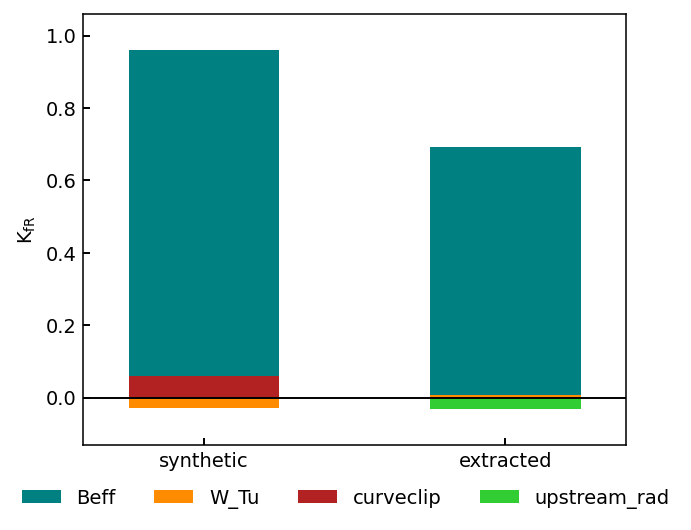

In [100]:
scalings = pd.DataFrame()
study_name = "fR"

for curve_name in curves["set"].keys():
    profiles = store_profiles[study_name]
    stores = store_outer[study_name]
    
    store = stores[curve_name]
    names = list(store.keys())

    # Compare last and first case only!!
    df1 = DLScase(store[names[0]]).get_stats_dataframe()
    df2 = DLScase(store[names[-1]]).get_stats_dataframe()
    scaling = test_scalings(df1, df2, "BxBt", cumulative = False)

    for col in scaling.columns:
        scalings.loc[curve_name, col] = 1/scaling.loc[0, col]
        
df = scalings.loc[:,["Beff", "W_Tu", "curveclip", "upstream_rad"]]

## Calculate weights for each parameter. log(param) / sum(log(param)). 
all = df.product(axis = 1).copy()
df = np.log10(df)
df = df.div(df.sum(axis=1), axis = 0)

K_factor = scalings["all"] * scalings["param_ratio"]  # Actual K_fR
df = df.mul(K_factor, axis = 0)   # Scale up the range to correct k_fR
df.add(K_factor-df["Beff"], axis = 0)  # Offset so that top of stacked bar equals k_fR

fig, ax = plt.subplots()

curve_names = df.index.values

weight_counts = {}
for param in df.columns:
    weight_counts[param] = df[param].values

bottom = np.zeros(len(df.index))
width = 0.5
for param, weight_count in weight_counts.items():
    p = ax.bar(curve_names, weight_count, width, label = param, bottom = bottom)
    
ax.grid(which = "both", visible = False)
xlim = ax.get_xlim()
ax.hlines(0, *xlim, color = "k", lw = 1, linestyle = "-")
ax.set_xlim(xlim)
fig.legend(ncols = 4, loc = "upper center", bbox_to_anchor = (0.5, 0.05), frameon = False)
ax.set_ylabel(r"$K_{fR}$")


,Beff,W_Tu,curveclip,upstream_rad
synthetic,0.992110,0.000902,0.091777,0.031346
extracted,0.668186,-0.016842,-0.021413,-0.054819
argon,0.807421,-0.060398,-0.050994,-0.069489


In [44]:
K_fR

synthetic    0.992110
extracted    0.668186
argon        0.807421
dtype: float64

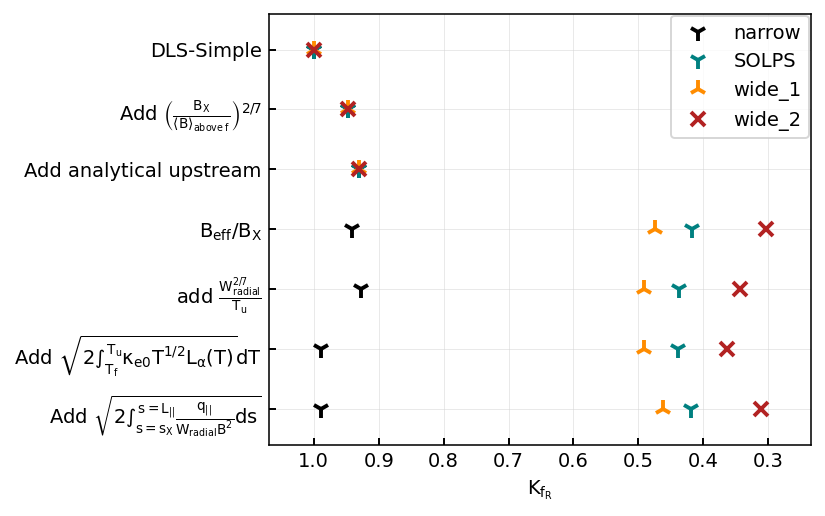

In [61]:
exponents = pd.DataFrame()

for curve_name in curves["set"].keys():
    # curve_name = "narrow"
    # curve_name = "shoulder"
    profiles = store_profiles["fR"]
    store = store_outer["fR"][curve_name]
    names = list(store.keys())

    # Compare last and first case only!!
    df1 = DLScase(store[names[0]]).get_stats_dataframe()
    df2 = DLScase(store[names[-1]]).get_stats_dataframe()
    scaling = test_scalings(df1, df2, "BxBt", cumulative = True)

    for col in scaling.drop(["result", "param_ratio"], axis = 1).columns:
        exponents.loc[curve_name, col] = (np.log(1/scaling[col]) / np.log(scaling["param_ratio"])).values[0]


fig, ax = plt.subplots()

dfplot = exponents[["simple_noavg_B", "simple", "abovex", "Beff", "W_Tu", "curveclip", "upstream_rad"]].copy()

labels = dict(simple_noavg_B = "DLS-Simple", 
              simple = r"Add $\left(\frac{B_X}{\langle B \rangle_{above\ f}}\right)^{2/7}$",
              abovex = "Add analytical upstream", 
              Beff = "$B_{eff}/B_{X}$",
              W_Tu = r"add $\frac{W_{radial}^{2/7}}{T_{u}}$",
              curveclip = r"Add ${\sqrt{2\int^{T_{u}}_{T_{f}} \kappa_{e0} T^{1/2}  L_{\alpha}(T) }dT}$", 
              upstream_rad = r"Add $\sqrt{2 \int^{s=L_{||}}_{s=s_{X}} \frac{q_{||}}{W_{radial}B^{2}}ds}$")

dfplot.rename(columns = labels, inplace = True)

curve_styles = dict(
    narrow = dict(marker = "1", ms = 9, markeredgewidth = 2, c = "black", markerfacecolor = "None"),
    SOLPS = dict(marker = "1", ms = 9, markeredgewidth = 2, markerfacecolor = "None"),
    wide_1 = dict(marker = "2", ms = 9, markeredgewidth = 2),
    wide_2 = dict(marker = "x", ms = 7, markeredgewidth = 2),
    argon = dict(marker = "v", ms = 6, markeredgewidth = 2, markerfacecolor = "None"),
    nitrogen = dict(marker = "d", ms = 6, markeredgewidth = 2, c = "darkorange", markerfacecolor = "None"),
    neon = dict(marker = "s", ms = 6, markeredgewidth = 2, c = "limegreen", markerfacecolor = "None")
)

for curve in dfplot.index:
    ax.plot(dfplot.loc[curve,:], dfplot.columns, lw = 0, label = curve, **curve_styles[curve])
    
ax.set_xlabel(r"$K_{f_R}$")
ax.invert_yaxis()
ax.invert_xaxis()
ax.legend()

# Compare individual cases

In [ ]:
comps_outer["fR"]["Curve 1"][2].dls.keys()

Index(['Qrad', 'Spar', 'Spol', 'Te', 'qpar', 'Btot', 'cz', 'Ne', 'Xpoint',
       'qradial', 'Prad_per_area', 'Prad_per_area_cum',
       'Prad_per_area_cum_norm', 'Prad_cum', 'Prad_cum_norm', 'Pe', 'Ne_sq_cz',
       'qpar_cond_frac'],
      dtype='object')

## fR Curve 1

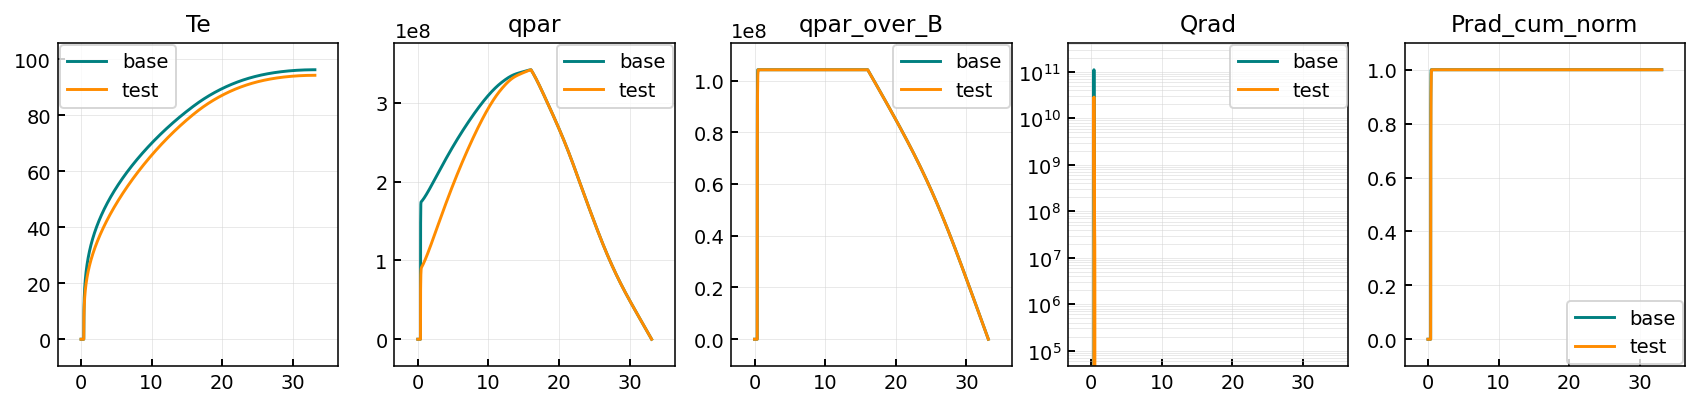

In [105]:

            
toplot = dict(
    base = comps_outer["fR"]["Curve 1"][2].dls,
    test = comps_outer["fR"]["Curve 1"][4].dls
)
params = ["Te", "qpar","qpar_over_B",  "Qrad", "Prad_cum_norm"]

xlims_zoom = (0.25, 0.75)
# xlims = dict(Qrad = xlims_zoom, Prad_per_area_cum_norm = xlims_zoom, Prad_cum_norm = xlims_zoom)
xlims = {}
scales = dict(Qrad = "log")

compare_dls(toplot, params, xlims = xlims, scales = scales)

## fR Curve 2

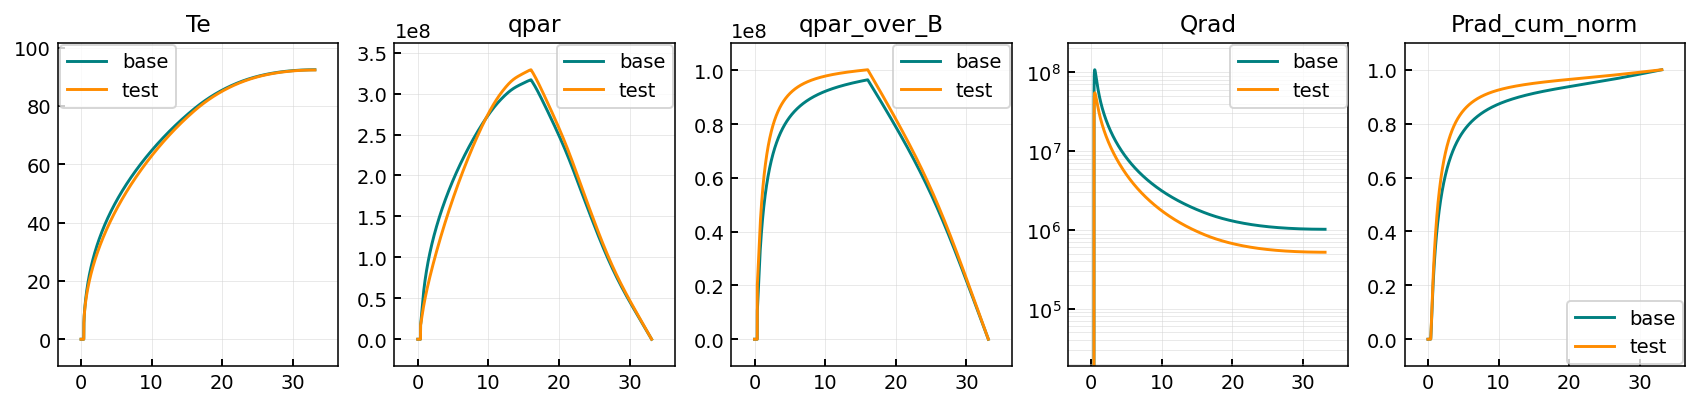

In [104]:
toplot = dict(
    base = comps_outer["fR"]["Curve 2"][2].dls,
    test = comps_outer["fR"]["Curve 2"][4].dls
)
params = ["Te", "qpar", "qpar_over_B", "Qrad", "Prad_cum_norm"]

xlims_zoom = (0, 35)
# xlims = dict(Qrad = xlims_zoom, Prad_per_area_cum_norm = xlims_zoom, Prad_cum_norm = xlims_zoom)
xlims = {}
scales = dict(Qrad = "log")

compare_dls(toplot, params, xlims = xlims, scales = scales)

## fR Curve 3

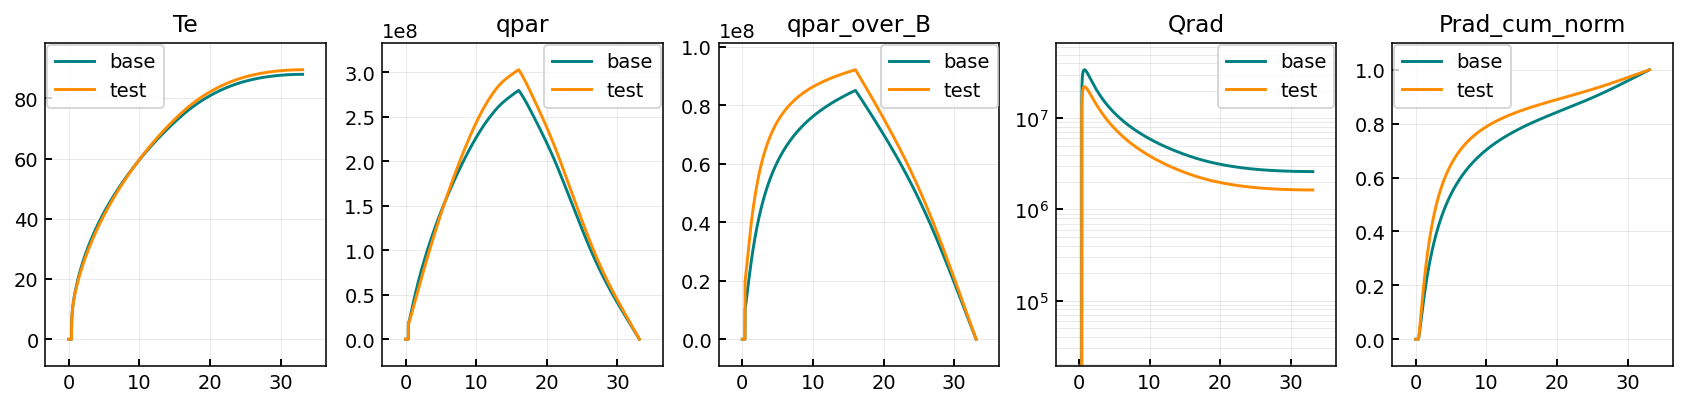

In [106]:
toplot = dict(
    base = comps_outer["fR"]["Curve 3"][2].dls,
    test = comps_outer["fR"]["Curve 3"][4].dls
)
params = ["Te", "qpar", "qpar_over_B", "Qrad", "Prad_cum_norm"]

xlims_zoom = (0, 35)
# xlims = dict(Qrad = xlims_zoom, Prad_per_area_cum_norm = xlims_zoom, Prad_cum_norm = xlims_zoom)
xlims = {}
scales = dict(Qrad = "log")

compare_dls(toplot, params, xlims = xlims, scales = scales)

## Inner: Lc Curve 1

In [141]:
comps_inner["Lc"]["Curve 1"].keys()

dict_keys([1, 1.5])

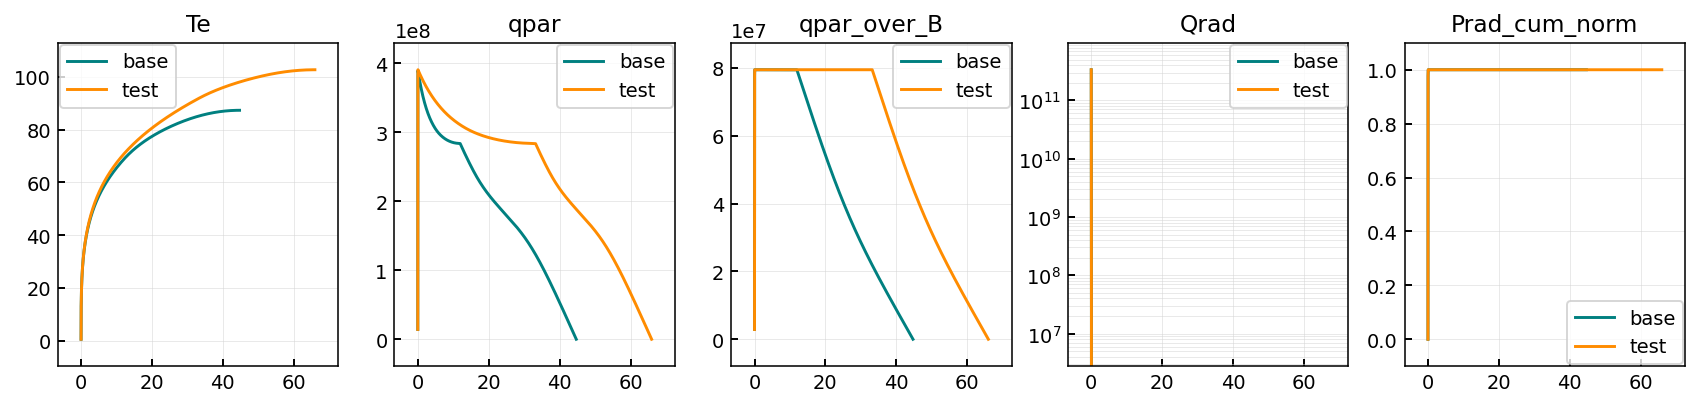

In [142]:
toplot = dict(
    base = comps_inner["Lc"]["Curve 1"][1].dls,
    test = comps_inner["Lc"]["Curve 1"][1.5].dls
)
params = ["Te", "qpar", "qpar_over_B", "Qrad", "Prad_cum_norm"]

xlims_zoom = (0, 35)
# xlims = dict(Qrad = xlims_zoom, Prad_per_area_cum_norm = xlims_zoom, Prad_cum_norm = xlims_zoom)
xlims = {}
scales = dict(Qrad = "log")

compare_dls(toplot, params, xlims = xlims, scales = scales)

# Front width evolution

In [98]:
comps = {"outer" : comps_outer, "inner" : comps_inner}

In [101]:
comps["outer"].keys()

dict_keys(['fR'])

## Front width: base

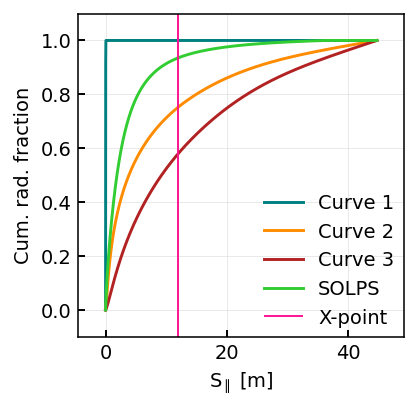

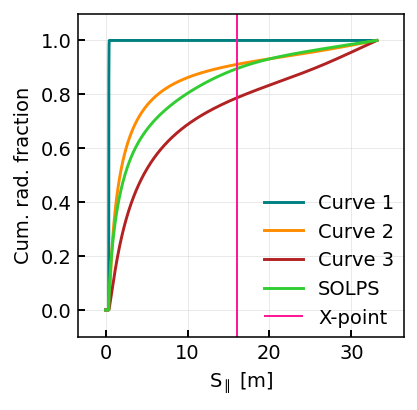

In [196]:
for side in ["inner", "outer"]: 

    fig, ax = plt.subplots(figsize = (3,3))

    for curve in curves[f"set_{side}"].keys():
        i = 1
        # for fR in store_profiles["fR"].keys():
        comp = comps[side]["Lc"][curve][i]
        dls = comp.dls
        ax.plot(dls["Spar"], dls["Prad_cum_norm"], label = curve)
        
    x = dls[dls["Xpoint"]==1].squeeze()
    ylim = ax.get_ylim()
    ax.vlines(x["Spar"], *ylim, lw = 1, color = "deeppink", label = "X-point")
    ax.set_ylim(ylim)
    ax.legend(frameon = False)
    ax.set_xlabel("$S_{\parallel}$ [m]")
    ax.set_ylabel("Cum. rad. fraction")

    # fig.savefig(rf"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\FrontEffects_frontwidths_{side}_lower.pdf", format = "pdf")

## Front width: fR

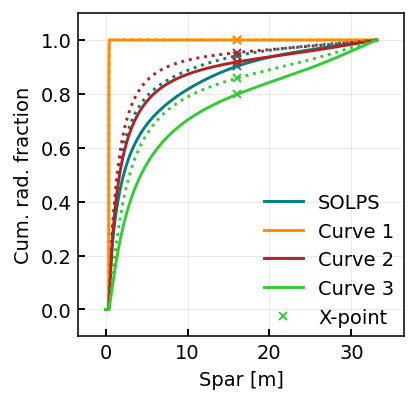

In [ ]:
colors = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

fig, ax = plt.subplots(figsize = (3,3))

for i, curve in enumerate(curves["set"].keys()):

    # for fR in store_profiles["fR"].keys():
    comp = comps_outer["fR"][curve][2]
    dls = comp.dls
    ax.plot(dls["Spar"], dls["Prad_cum_norm"], color = colors[i], label = curve)
    dlsx = dls[dls["Xpoint"]==1].squeeze()
    ax.plot(dlsx["Spar"], dlsx["Prad_cum_norm"], color = colors[i], marker = "x", ms = 4, lw = 0, label = "X-point" if i == len(curves["set"])-1 else "")
    
    comp = comps_outer["fR"][curve][4]
    dls = comp.dls
    ax.plot(dls["Spar"], dls["Prad_cum_norm"], color = colors[i], ls = ":")
    dlsx = dls[dls["Xpoint"]==1].squeeze()
    ax.plot(dlsx["Spar"], dlsx["Prad_cum_norm"], color = colors[i], marker = "x", ms = 4, lw = 0)
    

ax.legend(frameon = False)
ax.set_xlabel("Spar [m]")
ax.set_ylabel("Cum. rad. fraction")
fig.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\FrontEffects_fR_frontwidths.pdf", format = "pdf")


## Front width: Lc

Text(0.5, 1.0, 'Front widths before (solid) and after (dotted)')

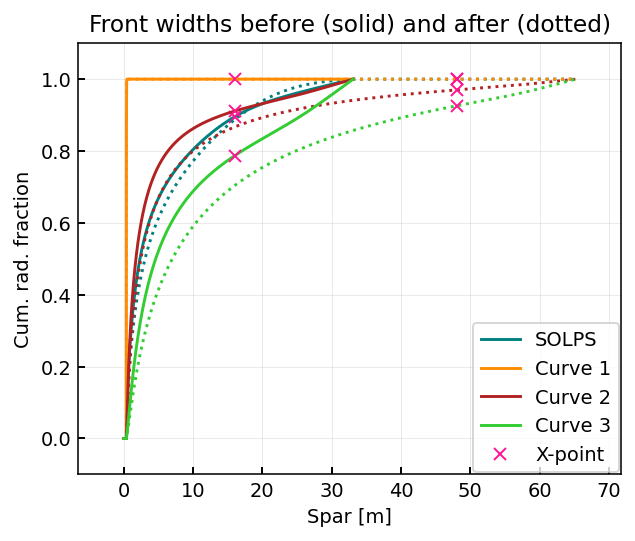

In [ ]:
colors = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

fig, ax = plt.subplots()

for i, curve in enumerate(curves["set"].keys()):

    # for fR in store_profiles["fR"].keys():
    comp = comps_outer["Lc"][curve][1]
    dls = comp.dls
    ax.plot(dls["Spar"], dls["Prad_cum_norm"], color = colors[i], label = curve)
    dlsx = dls[dls["Xpoint"]==1].squeeze()
    ax.plot(dlsx["Spar"], dlsx["Prad_cum_norm"], color = "deeppink", marker = "x", ms = 6, lw = 0, label = "X-point" if i == len(curves["set"])-1 else "")
    
    comp = comps_outer["Lc"][curve][2]
    dls = comp.dls
    ax.plot(dls["Spar"], dls["Prad_cum_norm"], color = colors[i], ls = ":")
    dlsx = dls[dls["Xpoint"]==1].squeeze()
    ax.plot(dlsx["Spar"], dlsx["Prad_cum_norm"], color = "deeppink", marker = "x", ms = 6, lw = 0)
    
# x = dls[dls["Xpoint"]==1].squeeze()
# ylim = ax.get_ylim()
# ax.vlines(x["Spar"], *ylim, lw = 1, color = "deeppink", label = "X-point")
# ax.set_ylim(ylim)
ax.legend()
ax.set_xlabel("Spar [m]")
ax.set_ylabel("Cum. rad. fraction")
ax.set_title("Front widths before (solid) and after (dotted)")


### wide_2 deep dive

Text(0.5, 1.04, 'wide_2')

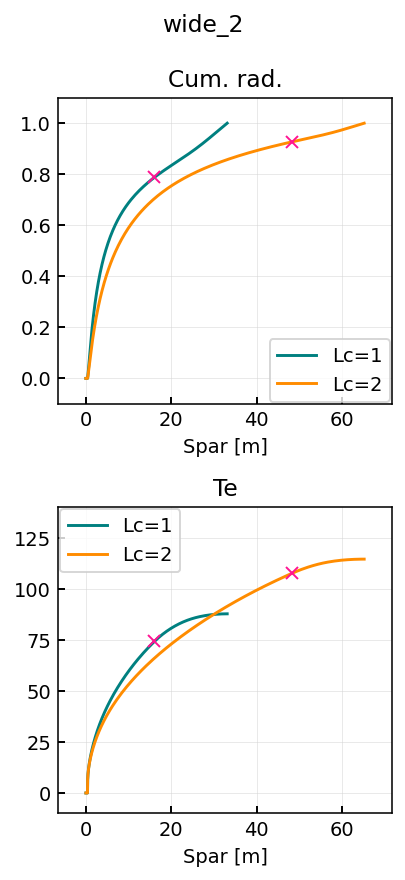

In [ ]:
colors = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

curve = "wide_2"

fig, axes = plt.subplots(2,1, figsize = (3,6))

dfs = {1 : comps_outer["Lc"][curve][1].dls, 2 : comps_outer["Lc"][curve][2].dls}
xpoint_style = dict(lw = 0, marker = "x", ms = 6, c = "deeppink")

for Lc in dfs.keys():
    df = dfs[Lc]
    dfx = df[df["Xpoint"]==1].squeeze()
    axes[0].plot(df["Spar"], df["Prad_cum_norm"], label = f"Lc={Lc}")
    axes[0].plot(dfx["Spar"], dfx["Prad_cum_norm"], **xpoint_style)
    axes[1].plot(df["Spar"], df["Te"], label = f"Lc={Lc}")
    axes[1].plot(dfx["Spar"], dfx["Te"], **xpoint_style)
    
for ax in axes:
    ax.set_xlabel("Spar [m]")
    ax.legend()
    
axes[0].set_title("Cum. rad.")
axes[1].set_title("Te")
axes[1].set_ylim(-10, 140)
fig.tight_layout()
fig.suptitle(curve, y = 1.04)
# dls = comp.dls
# comp.plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False)



# Sensitivity

In [ ]:
sepadd_select.keys()

dict_keys(['outer_lower', 'inner_lower'])

## Run outer

In [109]:
sepadd = sepadd_select["outer_lower"]
profile = store_profiles["outer"][study][2]
store_scan_outer = {}

for curve_name in curves["set_outer"].keys():
    print("Solving curve", curve_name, "-----------------------------------------")
    Lfunc = curves["set_outer"][curve_name]
    
    # set switches
    radios_default = {
        "upstreamGrid": True,  # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point.
    }

    df = slc.get_1d_poloidal_data(["Ne"], sepadd = sepadd, region = region, target_first = True)
    nu = df["Ne"].iloc[-1]

    # set general run parameters
    constants_default = {
        "gamma_sheath": 7,  # sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
        "Tt": 0.5,  # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
        "qpllu0": 3.42e8,
        "nu": nu,  # Upstream density (if constant)
        "nu0": nu,  # Upstream density (if constant)
        "cz0": 0.05,  # Impurity fraction (if constant)
        # "Lfunc": LfuncKallenbach("N"),  # impurity cooling function. More are available in AnalyticCoolingCurves.py
        "Lfunc" : Lfunc,
        "kappa0" : 2800
    }

    SpolRange = np.linspace(0, profile["Spol"][profile["Xpoint"]], 10) # 
    SparRange = [profile["S"][np.argmin(np.abs(profile["Spol"] - SpolRange[x]))] for x, _ in enumerate(SpolRange)]

    try: 
            out = run_dls(
                constants = constants_default, 
                radios = radios_default, 
                d = profile,
                SparRange = SparRange,
                control_variable = "density",
                verbosity = 0,
                Ctol = 1e-3,
                Ttol = 1e-3,
                dynamicGrid = True,
                dynamicGridRefinementRatio = 5,
                dynamicGridRefinementWidth = 2,
                dynamicGridResolution = 10000,
                dynamicGridDiagnosticPlot = False)
        
    except KeyboardInterrupt:
        print("Stopped")
        sys.exit(0)
        
    store_scan_outer[curve_name] = out


Solving curve Curve 1 -----------------------------------------
Solving...0.00...2.16...4.81...7.94...11.46...15.45...19.60...24.51...31.54...48.13...Complete in 12.1 seconds
Solving curve Curve 2 -----------------------------------------
Solving...0.00...2.16...4.81...7.94...11.46...15.45...19.60...24.51...31.54...48.13...Complete in 15.5 seconds
Solving curve Curve 3 -----------------------------------------
Solving...0.00...2.16...4.81...7.94...11.46...15.45...19.60...24.51...31.54...48.13...

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


Complete in 16.1 seconds
Solving curve SOLPS -----------------------------------------
Solving...0.00...2.16...4.81...7.94...11.46...15.45...19.60...24.51...31.54...48.13...

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


Complete in 20.6 seconds


## Run inner

In [127]:
sepadd = sepadd_select["inner_lower"]
profile = store_profiles["inner"][study][1]
store_scan_inner = {}

for curve_name in curves["set_inner"].keys():
    print("Solving curve", curve_name, "-----------------------------------------")
    Lfunc = curves["set_inner"][curve_name]
    
    # set switches
    radios_default = {
        "upstreamGrid": True,  # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point.
    }

    df = slc.get_1d_poloidal_data(["Ne"], sepadd = sepadd, region = region, target_first = True)
    nu = df["Ne"].iloc[-1]

    # set general run parameters
    constants_default = {
        "gamma_sheath": 7,  # sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
        "Tt": 0.5,  # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
        "qpllu0": 3.42e8 * 0.83,
        "nu": nu,  # Upstream density (if constant)
        "nu0": nu,  # Upstream density (if constant)
        "cz0": 0.05,  # Impurity fraction (if constant)
        # "Lfunc": LfuncKallenbach("N"),  # impurity cooling function. More are available in AnalyticCoolingCurves.py
        "Lfunc" : Lfunc,
        "kappa0" : 2800 * 1.73
    }

    SpolRange = np.linspace(0, profile["Spol"][profile["Xpoint"]], 10) # 
    SparRange = [profile["S"][np.argmin(np.abs(profile["Spol"] - SpolRange[x]))] for x, _ in enumerate(SpolRange)]

    try: 
            out = run_dls(
                constants = constants_default, 
                radios = radios_default, 
                d = profile,
                SparRange = SparRange,
                control_variable = "density",
                verbosity = 0,
                Ctol = 1e-3,
                Ttol = 1e-3,
                dynamicGrid = True,
                dynamicGridRefinementRatio = 5,
                dynamicGridRefinementWidth = 2,
                dynamicGridResolution = 10000,
                dynamicGridDiagnosticPlot = False)
        
    except KeyboardInterrupt:
        print("Stopped")
        sys.exit(0)
        
    store_scan_inner[curve_name] = out


Solving curve Curve 1 -----------------------------------------
Solving...0.00...0.51...1.08...1.71...2.44...3.46...

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


4.56...5.99...8.25...11.95...Complete in 11.0 seconds
Solving curve Curve 2 -----------------------------------------
Solving...0.00...

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


0.51...1.08...1.71...2.44...3.46...4.56...5.99...8.25...11.95...Complete in 16.5 seconds
Solving curve Curve 3 -----------------------------------------
Solving...0.00...

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


0.51...1.08...1.71...2.44...3.46...4.56...5.99...8.25...11.95...Complete in 16.9 seconds
Solving curve SOLPS -----------------------------------------
Solving...0.00...0.51...1.08...

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


1.71...2.44...3.46...4.56...5.99...8.25...11.95...Complete in 14.1 seconds


# Absolute threshold change

In [115]:
region = "outer_lower"

sepadd = sepadd_select[region]

conditions = pd.DataFrame()

slc = store_slc[case]

df = slc.get_1d_poloidal_data(
    ["Te", "Ne", "Nn", "fAr", "RAr","Btot", "fhx_total", "vol", "Rd+_exiz", "Rd+_mol"], 
    sepadd = sepadd, region = region, target_first = True)

name = "mp_puff"
# df = df.iloc[:-1] ## Take out guards


df["hf_par_tot"] = df["fhx_total"] / df["apar"]
dfx = df[df["Xpoint"]==1].squeeze()


conditions.loc[name, "Nu"] = df.iloc[-1]["Ne"]

conditions.loc[name, "qpllu"] = abs(dfx["hf_par_tot"])
conditions.loc[name, "front_loc"] = slc.extract_front_pos(sepadd = sepadd, region = region, impurity = "Ar", method = "qpar_total", threshold = 0.05)
conditions.loc[name, "front_loc_Te5eV"] = slc.extract_front_pos(sepadd = sepadd, impurity = "Ar", region = region, method = "Te", threshold = 5)

## Make radiation weighted average Cz 
Lz = slc.extract_cooling_curve("Ar", region="outer_lower", sepadd = 4,order = 8)
Qn = [Lz(T) for T in df["Te"]]  # Cooling rate in Wm3
PN = df["RAr"]  # Radiation power source in Wm-3
Ptot = df["RAr"] + df["Rd+_exiz"] + df["Rd+_mol"]

df_over5eV = df[df["Te"]>5]
df_noneutrals = df[df["Nn"] < df["Ne"]*0.1]

conditions.loc[name, "cz_volavg"] = (df["fAr"] * df["vol"]).sum() / df["vol"].sum()
conditions.loc[name, "cz_rad_volavg"] = (PN * df["vol"]).sum() / (Qn * df["Ne"]**2 * df["vol"]).sum()
conditions.loc[name, "cz_radtot_volavg"] = (Ptot * df["vol"]).sum() / (Qn * df["Ne"]**2 * df["vol"]).sum()
conditions.loc[name, "cz_over5eV_volavg"] = (df_over5eV["fAr"] * df_over5eV["vol"]).sum() / df_over5eV["vol"].sum()
conditions.loc[name, "cz_noneutrals_volavg"] = (df_noneutrals["fAr"] * df_noneutrals["vol"]).sum() / df_noneutrals["vol"].sum()
conditions.loc[name, "cz_xpoint"] = dfx["fAr"]
    
for col in conditions.columns:
    if "cz" in col:
        conditions[col.replace("cz", "C")] = conditions[col]**(0.5) * conditions["Nu"] * conditions["qpllu"]**(-5/7)
        
for col in conditions.columns:
    if "cz" in col:        
        conditions[col.replace("cz", "Cnorm")] = conditions[col.replace("cz", "C")] / conditions[col.replace("cz", "C")].iloc[0]

# conditions_
# fig, ax = plt.subplots()
# ax.plot(conditions["cz_avg"], conditions["front_loc"])
display(conditions.T)

,mp_puff
Nu,2.426772e+19
qpllu,3.050983e+08
front_loc,3.829107e-01
front_loc_Te5eV,5.194994e-01
cz_volavg,2.750002e-02
cz_rad_volavg,4.228628e-02
cz_radtot_volavg,3.354293e-02
cz_over5eV_volavg,2.637155e-02
cz_noneutrals_volavg,2.711411e-02
cz_xpoint,2.108840e-02


## Bar plot of C

In [110]:
Cs = dict(
    C_volavg = "Volumetric average",
    C_rad_volavg = "Rad. weighted vol. avg",
    C_radtot_volavg = "Total rad. weighted vol. avg",
    C_over5eV_volavg = "Rad. weighted vol. avg $T_e > 5eV$",
    C_noneutrals_volavg = "Rad. weighted vol. avg $N_n < 0.1 N_e$",
    C_xpoint = "cz at X-point"
)

In [111]:
dc = DLScase(out)
df = dc.get_stats_dataframe()
df

,cvar,kappa0,Bf,Bx,Beff,BxBt,BxBteff,Lc,Wradial,Tu,avgB_ratio,upstream_rad,W_Tu,W_Tu_simple,curveclip
0,2.867145e+19,2800.0,1.812058,3.283243,2.175769,1.811887,1.509004,16.652238,1.567838e+07,120.29286,1.211535,6.642044,0.139992,0.315222,1.262083e+12


## Bar breakdown

### Outer`

In [125]:
thresh = pd.DataFrame()

for curve_name in curves["set_outer"].keys():
    dc = DLScase(store_scan_outer[curve_name]).get_stats_dataframe()
    
    thresh.loc[curve_name, "Beff"] = dc["Beff"].values[0]
    thresh.loc[curve_name, "W_Tu"] = dc["W_Tu"].values[0]
    thresh.loc[curve_name, "curveclip"] = dc["curveclip"].values[0]
    thresh.loc[curve_name, "upstream_rad"] = dc["upstream_rad"].values[0]
    
relthresh  = thresh.copy()
relthresh /= relthresh.iloc[0,:]
thresh["total"] = thresh.product(axis = 1)
display(thresh)
display(relthresh)
# thresh / thresh.loc["Curve 1"]
# thresh

,Beff,W_Tu,curveclip,upstream_rad,total
Curve 1,1.812173,0.137205,7.424949e+12,6.638532,1.225558e+13
Curve 2,2.199178,0.141111,1.260189e+12,6.562987,2.566602e+12
Curve 3,2.471006,0.145759,8.984077e+11,6.431152,2.080997e+12
SOLPS,2.175769,0.139992,1.262083e+12,6.642044,2.553321e+12


,Beff,W_Tu,curveclip,upstream_rad
Curve 1,1.000000,1.000000,1.000000,1.000000
Curve 2,1.213559,1.028471,0.169724,0.988620
Curve 3,1.363560,1.062348,0.120999,0.968761
SOLPS,1.200641,1.020315,0.169979,1.000529


### Inner

In [130]:
thresh = pd.DataFrame()

for curve_name in curves["set_inner"].keys():
    dc = DLScase(store_scan_inner[curve_name]).get_stats_dataframe()
    
    thresh.loc[curve_name, "Beff"] = dc["Beff"].values[0]
    thresh.loc[curve_name, "W_Tu"] = dc["W_Tu"].values[0]
    thresh.loc[curve_name, "curveclip"] = dc["curveclip"].values[0]
    thresh.loc[curve_name, "upstream_rad"] = dc["upstream_rad"].values[0]
    
relthresh  = thresh.copy()
relthresh /= relthresh.iloc[0,:]
relthresh["total"] = relthresh.product(axis = 1)
thresh["total"] = thresh.product(axis = 1)
display(thresh)
display(relthresh)
# thresh / thresh.loc["Curve 1"]
# thresh

,Beff,W_Tu,curveclip,upstream_rad,total
Curve 1,4.921076,0.150501,5.647277e+12,6.964420,2.912883e+13
Curve 2,4.449891,0.158917,2.289524e+12,6.494873,1.051566e+13
Curve 3,3.970271,0.180803,9.935632e+11,5.586252,3.984205e+12
SOLPS,4.107365,0.156861,1.408918e+12,6.842627,6.211351e+12


,Beff,W_Tu,curveclip,upstream_rad,total
Curve 1,1.000000,1.000000,1.000000,1.000000,1.000000
Curve 2,0.904252,1.055923,0.405421,0.932579,0.361005
Curve 3,0.806789,1.201342,0.175937,0.802113,0.136779
SOLPS,0.834648,1.042258,0.249486,0.982512,0.213237


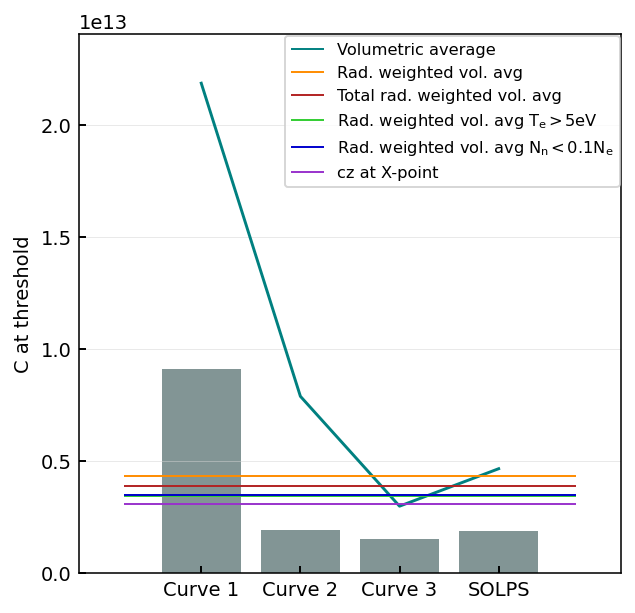

In [145]:
weights = dict()
for curve_name in curves["set_outer"].keys():
    out = store_scan_outer[curve_name]
    # ax.plot(out["cvar"] / out["cvar"][0], out["SpolPlot"], marker = "o", label = curve_name)
    
    qpll = out["state"].si.qpllu0
    nu = out["cvar"]
    cz = out["state"].si.cz0

    C = qpll**(-5/7) * nu * cz**0.5
    weights[curve_name] = C[0]
    
fig, ax = plt.subplots(figsize = (5,5))

ax.bar(curves["set_outer"].keys(), weights.values(), color = "darkslategrey", alpha = 0.6)

# for curve_name in curves["set_outer"].keys():
ax.plot(thresh.index, thresh["total"]*0.75)

xlim = ax.get_xlim()
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for i, C_definition in enumerate(Cs):
    ax.hlines(conditions[C_definition], *xlim, lw = 1, label = Cs[C_definition], color = colors[i])
    
ax.legend(fontsize = "small")
ax.set_ylabel("C at threshold")
ax.grid(axis = "x", which = "both", visible = False)

## Old bars

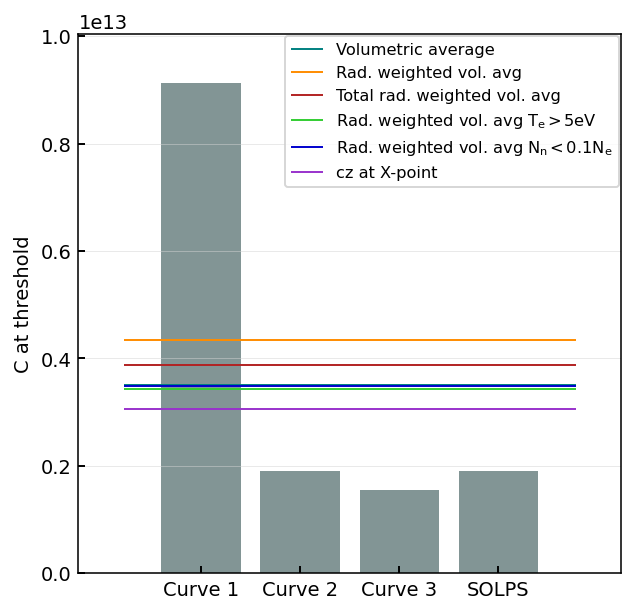

In [146]:
weights = dict()
for curve_name in curves["set_outer"].keys():
    out = store_scan_outer[curve_name]
    # ax.plot(out["cvar"] / out["cvar"][0], out["SpolPlot"], marker = "o", label = curve_name)
    
    qpll = out["state"].si.qpllu0
    nu = out["cvar"]
    cz = out["state"].si.cz0

    C = qpll**(-5/7) * nu * cz**0.5
    weights[curve_name] = C[0]
    
fig, ax = plt.subplots(figsize = (5,5))

ax.bar(curves["set_outer"].keys(), weights.values(), color = "darkslategrey", alpha = 0.6)

xlim = ax.get_xlim()
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for i, C_definition in enumerate(Cs):
    ax.hlines(conditions[C_definition], *xlim, lw = 1, label = Cs[C_definition], color = colors[i])
    
ax.legend(fontsize = "small")
ax.set_ylabel("C at threshold")
ax.grid(axis = "x", which = "both", visible = False)

mp_puff    3.502527e+12
Name: C_volavg, dtype: float64
mp_puff    4.343248e+12
Name: C_rad_volavg, dtype: float64
mp_puff    3.868258e+12
Name: C_radtot_volavg, dtype: float64
mp_puff    3.429910e+12
Name: C_over5eV_volavg, dtype: float64
mp_puff    3.477864e+12
Name: C_noneutrals_volavg, dtype: float64
mp_puff    3.067162e+12
Name: C_xpoint, dtype: float64


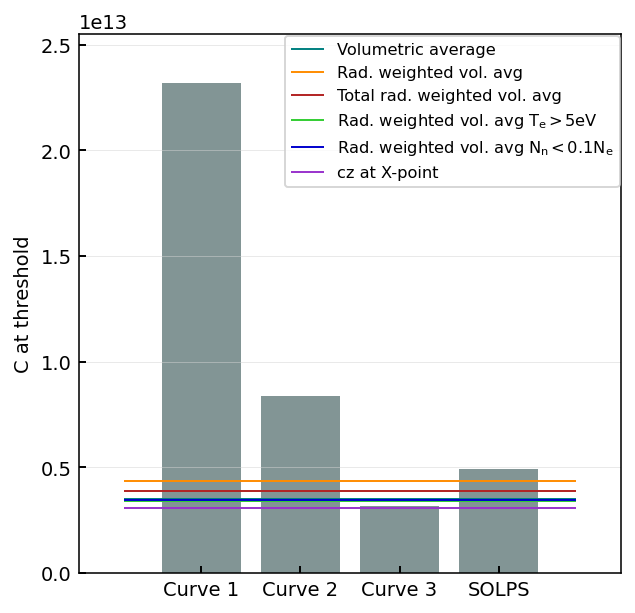

In [147]:
weights = dict()
for curve_name in curves["set_inner"].keys():
    out = store_scan_inner[curve_name]
    # ax.plot(out["cvar"] / out["cvar"][0], out["SpolPlot"], marker = "o", label = curve_name)
    
    qpll = out["state"].si.qpllu0
    nu = out["cvar"]
    cz = out["state"].si.cz0

    C = qpll**(-5/7) * nu * cz**0.5
    weights[curve_name] = C[0]
    
fig, ax = plt.subplots(figsize = (5,5))

ax.bar(curves["set_inner"].keys(), weights.values(), color = "darkslategrey", alpha = 0.6)

xlim = ax.get_xlim()
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for i, C_definition in enumerate(Cs):
    print(conditions[C_definition])
    ax.hlines(conditions[C_definition], *xlim, lw = 1, label = Cs[C_definition], color = colors[i])
    
ax.legend(fontsize = "small")
ax.set_ylabel("C at threshold")
ax.grid(axis = "x", which = "both", visible = False)

Text(0, 0.5, 'Spar')

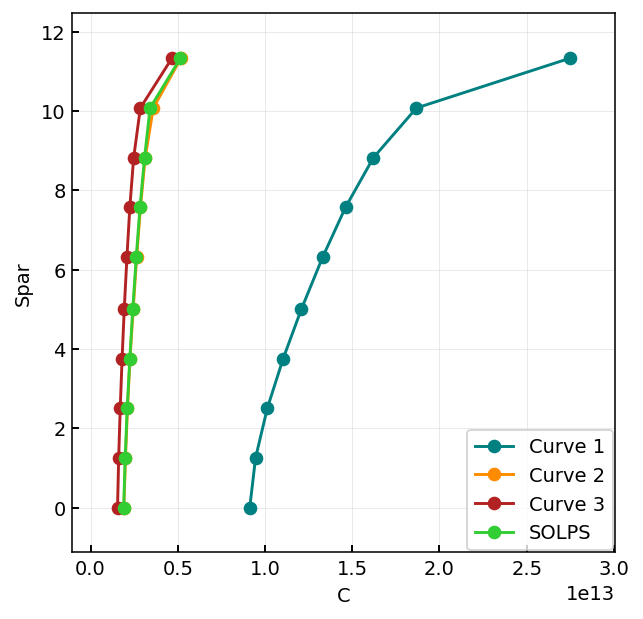

In [133]:
fig, ax = plt.subplots(figsize = (5,5))
for curve_name in curves["set_outer"].keys():
    out = store_scan_outer[curve_name]
    # ax.plot(out["cvar"] / out["cvar"][0], out["SpolPlot"], marker = "o", label = curve_name)
    
    qpll = out["state"].si.qpllu0
    nu = out["cvar"]
    cz = out["state"].si.cz0

    C = qpll**(-5/7) * nu * cz**0.5

    ax.plot(C, out["SpolPlot"], marker = "o", label = curve_name)
    
ax.legend()
ax.set_xlabel("C")
ax.set_ylabel("Spar")



Text(0, 0.5, 'Spar')

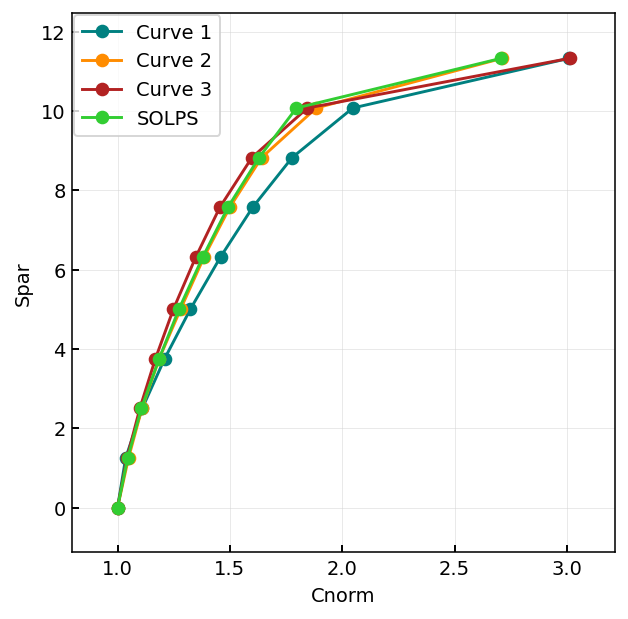

In [134]:
fig, ax = plt.subplots(figsize = (5,5))
for curve_name in curves["set_outer"].keys():
    out = store_scan_outer[curve_name]
    # ax.plot(out["cvar"] / out["cvar"][0], out["SpolPlot"], marker = "o", label = curve_name)
    ax.plot(out["cvar"]/out["cvar"][0], out["SpolPlot"], marker = "o", label = curve_name)
    
ax.legend()
ax.set_xlabel("Cnorm")
ax.set_ylabel("Spar")

Text(0, 0.5, 'Spar')

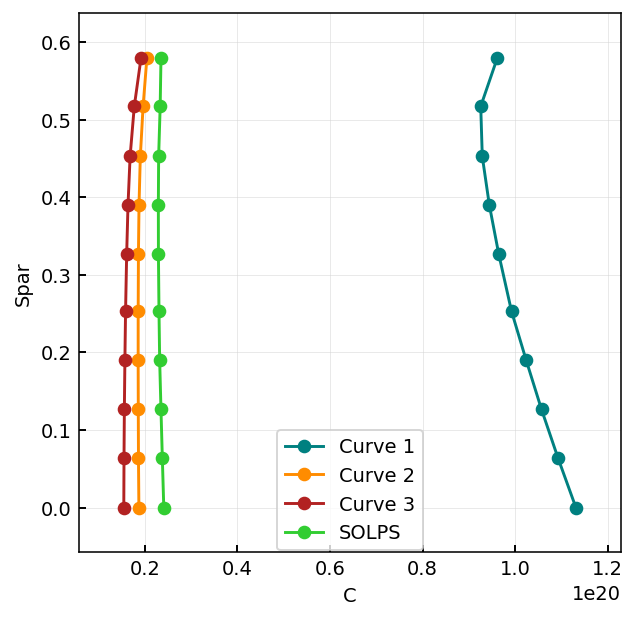

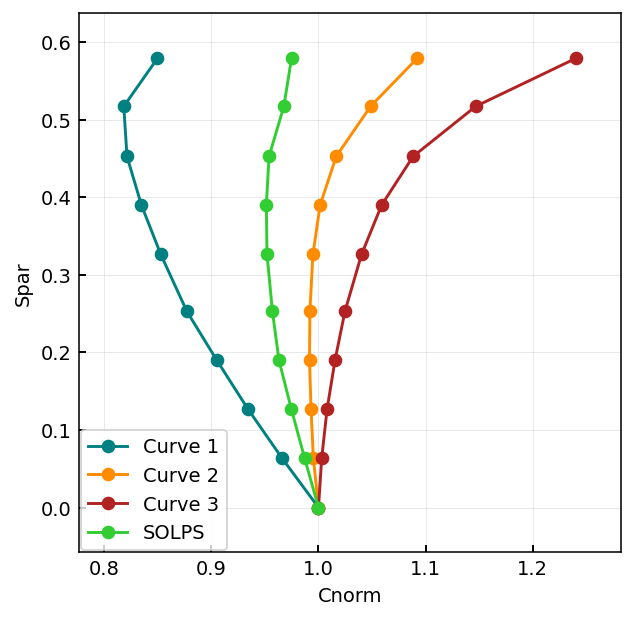

In [132]:
fig, ax = plt.subplots(figsize = (5,5))
for curve_name in curves["set_outer"].keys():
    out = store_scan_inner[curve_name]
    # ax.plot(out["cvar"] / out["cvar"][0], out["SpolPlot"], marker = "o", label = curve_name)
    ax.plot(out["cvar"], out["SpolPlot"], marker = "o", label = curve_name)
    
ax.legend()
ax.set_xlabel("C")
ax.set_ylabel("Spar")

fig, ax = plt.subplots(figsize = (5,5))
for curve_name in curves["set_outer"].keys():
    out = store_scan_inner[curve_name]
    # ax.plot(out["cvar"] / out["cvar"][0], out["SpolPlot"], marker = "o", label = curve_name)
    ax.plot(out["cvar"]/out["cvar"][0], out["SpolPlot"], marker = "o", label = curve_name)
    
ax.legend()
ax.set_xlabel("Cnorm")
ax.set_ylabel("Spar")